### Global Data.

The Global data was using regression models to predict Values using certain crops and all the countries across the globe. This proved to initially be tricky and confusing as I tried to do the predictions without the countries incliuded which obviously confused the model and gave poor results. However including a dummified set of global countries in the dataset imporved the scores by pretty much over 100 times.

The EDA was relatively simple as it was mainly just cleaning out the columns and the NA values in the data. The columns dropped were ones such as the elememnt code which is irrelevant to the rest of the data and thus is not required for the predictions. However I did try to perform a heat map and pairplot to see the correlations between the values and only the crops. This gave a poor heatmap and an equally poor result with the pairplot. So instgead I chose to show value output of the crops per country across the globe.

In terms of difficulties the most difficult part was dealing with the sheer size of the dataset as it has over 2 million rows which gets cut down significantly to only include the desired crops for the task.

The R2 scores were not amazing and the Ridge/lasso models either didn't really improve the scores or actually made them a bit worse. The coefficients showed a huge bias that was including the entire global output as one column which is clearly going to affect the result of the values. Testing without the entire global output as one column will be done to see how the scores perform.

In conclusion the model can predict the value output of particular crops relatively well just as long as you include the various countries. Without the countries you will be getting scores of 0.001 and worse. The values that have the greatest impact on the value output appears to be the actual countries themselves. The crops have a negative impact on the prediction of the value output. The crops do seem to have a greater feature importance however which suggests that 

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Setting the elastic model to a variable to help with the function as well as setting the figure size for graphs and visualisations to larger sizes due to the amount of columns that will be included.

In [2]:
elastic = ElasticNetCV(alphas=np.logspace(-4, 4, 10), cv=5)

In [3]:
sns.set(rc={'figure.figsize':(25,20),
           'font.size':20})

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### The global dataset was too big to upload normally to github so it was turned into a zip file. Here it is being unzipped to be used.  

##### WARNING PLEASE RUN ALL THE CODE BECAUSE AT THE END IT REMOVES THE CSV FILE AND THE MACOSX WHICH ARE TOO LARGE TO UPLOAD TO GITHUB.

In [5]:
!unzip -o global_crops.csv.zip

Archive:  global_crops.csv.zip
  inflating: global_crops.csv        
   creating: __MACOSX/
  inflating: __MACOSX/._global_crops.csv  


In [6]:
# read in data
# global crops data + dict
glob = pd.read_csv('./global_crops.csv')
glob_dict = pd.read_csv('./world_crops.csv')



#### Initial cleaning and dropping of columns.

In [7]:
glob = glob.drop(columns = ['element', 'value_footnotes','element_code'], axis = 1)

In [8]:
glob.head()

country_or_area    year unit    value          category
0      Americas +  2007.0   Ha  49404.0  agave_fibres_nes
1      Americas +  2006.0   Ha  49404.0  agave_fibres_nes
2      Americas +  2005.0   Ha  49404.0  agave_fibres_nes
3      Americas +  2004.0   Ha  49113.0  agave_fibres_nes
4      Americas +  2003.0   Ha  48559.0  agave_fibres_nes

In [9]:
glob.shape

(2255349, 5)

In [10]:
glob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255349 entries, 0 to 2255348
Data columns (total 5 columns):
country_or_area    object
year               float64
unit               object
value              float64
category           object
dtypes: float64(2), object(3)
memory usage: 86.0+ MB


In [11]:
glob.describe(include='all')

country_or_area          year     unit         value       category
count          2255349  2.254385e+06  2254385  2.254385e+06        2255349
unique             259           NaN        5           NaN            172
top            World +           NaN   tonnes           NaN  cereals_total
freq             27683           NaN   896776           NaN          92976
mean               NaN  1.984476e+03      NaN  1.502604e+06            NaN
std                NaN  1.364689e+01      NaN  1.951985e+07            NaN
min                NaN  1.961000e+03      NaN  0.000000e+00            NaN
25%                NaN  1.973000e+03      NaN  8.500000e+02            NaN
50%                NaN  1.985000e+03      NaN  1.374200e+04            NaN
75%                NaN  1.996000e+03      NaN  1.031890e+05            NaN
max                NaN  2.007000e+03      NaN  2.351396e+09            NaN

In [12]:
glob.isnull().sum()

country_or_area      0
year               964
unit               964
value              964
category             0
dtype: int64

In [13]:
glob_clean = glob.dropna()

In [14]:
glob_clean.isnull().sum()

country_or_area    0
year               0
unit               0
value              0
category           0
dtype: int64

In [15]:
glob_clean.category.unique()

array(['agave_fibres_nes', 'almonds_with_shell',
       'anise_badian_fennel_corian', 'apples', 'apricots', 'arecanuts',
       'artichokes', 'asparagus', 'avocados', 'bambara_beans', 'bananas',
       'barley', 'beans_dry', 'beans_green', 'berries_nes', 'blueberries',
       'brazil_nuts_with_shell', 'broad_beans_horse_beans_dry',
       'buckwheat', 'cabbages_and_other_brassicas', 'canary_seed',
       'carobs', 'carrots_and_turnips', 'cashew_nuts_with_shell',
       'cashewapple', 'cassava', 'castor_oil_seed',
       'cauliflowers_and_broccoli', 'cereals_nes',
       'cereals_rice_milled_eqv', 'cereals_total', 'cherries',
       'chestnuts', 'chick_peas', 'chicory_roots',
       'chillies_and_peppers_dry', 'chillies_and_peppers_green',
       'cinnamon_canella', 'citrus_fruit_nes', 'citrus_fruit_total',
       'cloves', 'coarse_grain_total', 'cocoa_beans', 'coconuts',
       'coffee_green', 'coir', 'cow_peas_dry', 'cranberries',
       'cucumbers_and_gherkins', 'currants', 'dates',


In [16]:
mean_crop = glob_clean.groupby('category')[['value']].mean()

In [17]:
mean_crop.sort_values('value', ascending='False')

value
category                                
vanilla                     2.693539e+03
gums_natural                6.277217e+03
pyrethrum_dried             6.958983e+03
poppy_seed                  8.336622e+03
hops                        9.886385e+03
blueberries                 1.027795e+04
hempseed                    1.182896e+04
agave_fibres_nes            1.215932e+04
nutmeg_mace_and_cardamoms   1.246595e+04
cinnamon_canella            1.332627e+04
canary_seed                 1.386667e+04
quinoa                      1.538858e+04
pepper_piper_spp            1.679710e+04
nuts_nes                    1.704104e+04
anise_badian_fennel_corian  1.857520e+04
bambara_beans               1.996907e+04
pistachios                  2.040913e+04
raspberries                 2.075789e+04
hemp_tow_waste              2.497210e+04
gooseberries                2.593008e+04
cranberries                 2.616063e+04
peppermint                  2.638704e+04
manila_fibre_abaca          2.995270e+04
ramie                       3.010315e+04
stone_fruit_nes             3.016755e+04
mustard_seed                3.079940e+04
kiwi_fruit                  3.341392e+04
berries_nes                 3.482592e+04
hazelnuts_with_shell        3.521031e+04
cloves                      3.557015e+04
...                                  ...
coconuts                    7.250542e+05
rye                         7.264335e+05
oats                        8.050316e+05
pulses_total                8.361532e+05
plantains                   9.009977e+05
millet                      9.262682e+05
mushrooms_and_truffles      9.352863e+05
grapes                      1.033398e+06
sorghum                     1.061998e+06
seed_cotton                 1.079562e+06
vegetables_fresh_nes        1.176690e+06
oilcrops_primary            1.478360e+06
soybeans                    1.521208e+06
oil_palm_fruit              1.734449e+06
sweet_potatoes              1.782386e+06
oilcakes_equivalent         1.812655e+06
cassava                     2.116690e+06
barley                      2.137743e+06
potatoes                    2.378955e+06
fruit_excl_melons_total     2.877373e+06
vegetables_melons_total     3.621328e+06
maize                       3.709909e+06
roots_and_tubers_total      4.214383e+06
sugar_beet                  5.304771e+06
rice_paddy                  5.502839e+06
wheat                       6.084577e+06
coarse_grain_total          6.746852e+06
cereals_total               7.054832e+06
sugar_cane                  9.949987e+06
cereals_rice_milled_eqv     1.387798e+07

[172 rows x 1 columns]

#### Setting the data to be only particular crops and thus reducing the size of the dataset significantly.

In [18]:
glob_polish = glob_clean[(glob_clean['category'] == 'cereals_total')|
                         (glob_clean['category'] == 'sugar_cane') | (glob_clean['category'] == 'coarse_grain_total') |
                         (glob_clean['category'] == 'wheat') | (glob_clean['category'] == 'rice_paddy')]

In [19]:
glob_polish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205146 entries, 364493 to 2239303
Data columns (total 5 columns):
country_or_area    205146 non-null object
year               205146 non-null float64
unit               205146 non-null object
value              205146 non-null float64
category           205146 non-null object
dtypes: float64(2), object(3)
memory usage: 9.4+ MB


In [20]:
glob_polish.drop('unit', inplace=True, axis=1)

In [21]:
glob_polish.head()

country_or_area    year     value       category
364493     Afghanistan  2007.0  226250.0  cereals_total
364494     Afghanistan  2006.0  251495.0  cereals_total
364495     Afghanistan  2005.0  248575.0  cereals_total
364496     Afghanistan  2004.0  245015.0  cereals_total
364497     Afghanistan  2003.0  215475.0  cereals_total

In [22]:
glob_polish.dtypes

country_or_area     object
year               float64
value              float64
category            object
dtype: object

#### The Year needs to be converted to a date time set.

In [23]:
list(set(glob_polish['year']))

[1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0]

In [24]:
year_ = glob_polish['year'].astype(str)

In [25]:
#glob_polish['year'] = pd.to_datetime(glob_polish['year']).dt.year
glob_polish['year'] = pd.to_datetime((year_), format='%Y.0').dt.year

In [26]:
list(set(glob_polish['year']))

[1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007]

In [27]:
glob_polish.head()

country_or_area  year     value       category
364493     Afghanistan  2007  226250.0  cereals_total
364494     Afghanistan  2006  251495.0  cereals_total
364495     Afghanistan  2005  248575.0  cereals_total
364496     Afghanistan  2004  245015.0  cereals_total
364497     Afghanistan  2003  215475.0  cereals_total

#### Creating a graph to show the value output of wheat from each country 

In [28]:
glob_polish[glob_polish['category']=='wheat']

country_or_area  year     value category
2213223     Afghanistan  2007  181815.0    wheat
2213224     Afghanistan  2006  209610.0    wheat
2213225     Afghanistan  2005  207740.0    wheat
2213226     Afghanistan  2004  199070.0    wheat
2213227     Afghanistan  2003  160480.0    wheat
2213228     Afghanistan  2002  197200.0    wheat
2213229     Afghanistan  2001  148070.0    wheat
2213230     Afghanistan  2000  151215.0    wheat
2213231     Afghanistan  1999  172464.0    wheat
2213232     Afghanistan  1998  172295.0    wheat
2213233     Afghanistan  1997  185810.0    wheat
2213234     Afghanistan  1996  180540.0    wheat
2213235     Afghanistan  1995  174250.0    wheat
2213236     Afghanistan  1994  170000.0    wheat
2213237     Afghanistan  1993  170000.0    wheat
2213238     Afghanistan  1992  161500.0    wheat
2213239     Afghanistan  1991  136000.0    wheat
2213240     Afghanistan  1990  143650.0    wheat
2213241     Afghanistan  1989  133450.0    wheat
2213242     Afghanistan  1988  136850.0    wheat
2213243     Afghanistan  1987  137700.0    wheat
2213244     Afghanistan  1986  152150.0    wheat
2213245     Afghanistan  1985  137615.0    wheat
2213246     Afghanistan  1984  144075.0    wheat
2213247     Afghanistan  1983  151384.0    wheat
2213248     Afghanistan  1982  155804.0    wheat
2213249     Afghanistan  1981  165240.0    wheat
2213250     Afghanistan  1980  170000.0    wheat
2213251     Afghanistan  1979  172720.0    wheat
2213252     Afghanistan  1978  183770.0    wheat
...                 ...   ...       ...      ...
2239274        Zimbabwe  1990  325983.0    wheat
2239275        Zimbabwe  1989  283835.0    wheat
2239276        Zimbabwe  1988  256910.0    wheat
2239277        Zimbabwe  1987  214548.0    wheat
2239278        Zimbabwe  1986  248346.0    wheat
2239279        Zimbabwe  1985  207200.0    wheat
2239280        Zimbabwe  1984   99000.0    wheat
2239281        Zimbabwe  1983  124250.0    wheat
2239282        Zimbabwe  1982  191880.0    wheat
2239283        Zimbabwe  1981  183516.0    wheat
2239284        Zimbabwe  1980  191234.0    wheat
2239285        Zimbabwe  1979  161963.0    wheat
2239286        Zimbabwe  1978  203052.0    wheat
2239287        Zimbabwe  1977  164540.0    wheat
2239288        Zimbabwe  1976  141433.0    wheat
2239289        Zimbabwe  1975  121083.0    wheat
2239290        Zimbabwe  1974   97383.0    wheat
2239291        Zimbabwe  1973   83921.0    wheat
2239292        Zimbabwe  1972   82037.0    wheat
2239293        Zimbabwe  1971   87184.0    wheat
2239294        Zimbabwe  1970   54127.0    wheat
2239295        Zimbabwe  1969   38938.0    wheat
2239296        Zimbabwe  1968   26222.0    wheat
2239297        Zimbabwe  1967   14051.0    wheat
2239298        Zimbabwe  1966    8878.0    wheat
2239299        Zimbabwe  1965    3810.0    wheat
2239300        Zimbabwe  1964    3865.0    wheat
2239301        Zimbabwe  1963    1869.0    wheat
2239302        Zimbabwe  1962    1216.0    wheat
2239303        Zimbabwe  1961     807.0    wheat

[26081 rows x 4 columns]

In [29]:
cou = glob_polish.groupby('country_or_area')['value'].mean()

In [30]:
cou = pd.DataFrame(cou)

In [31]:
cou.head(2)

value
country_or_area              
Afghanistan      5.988861e+05
Africa +         1.620749e+07

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

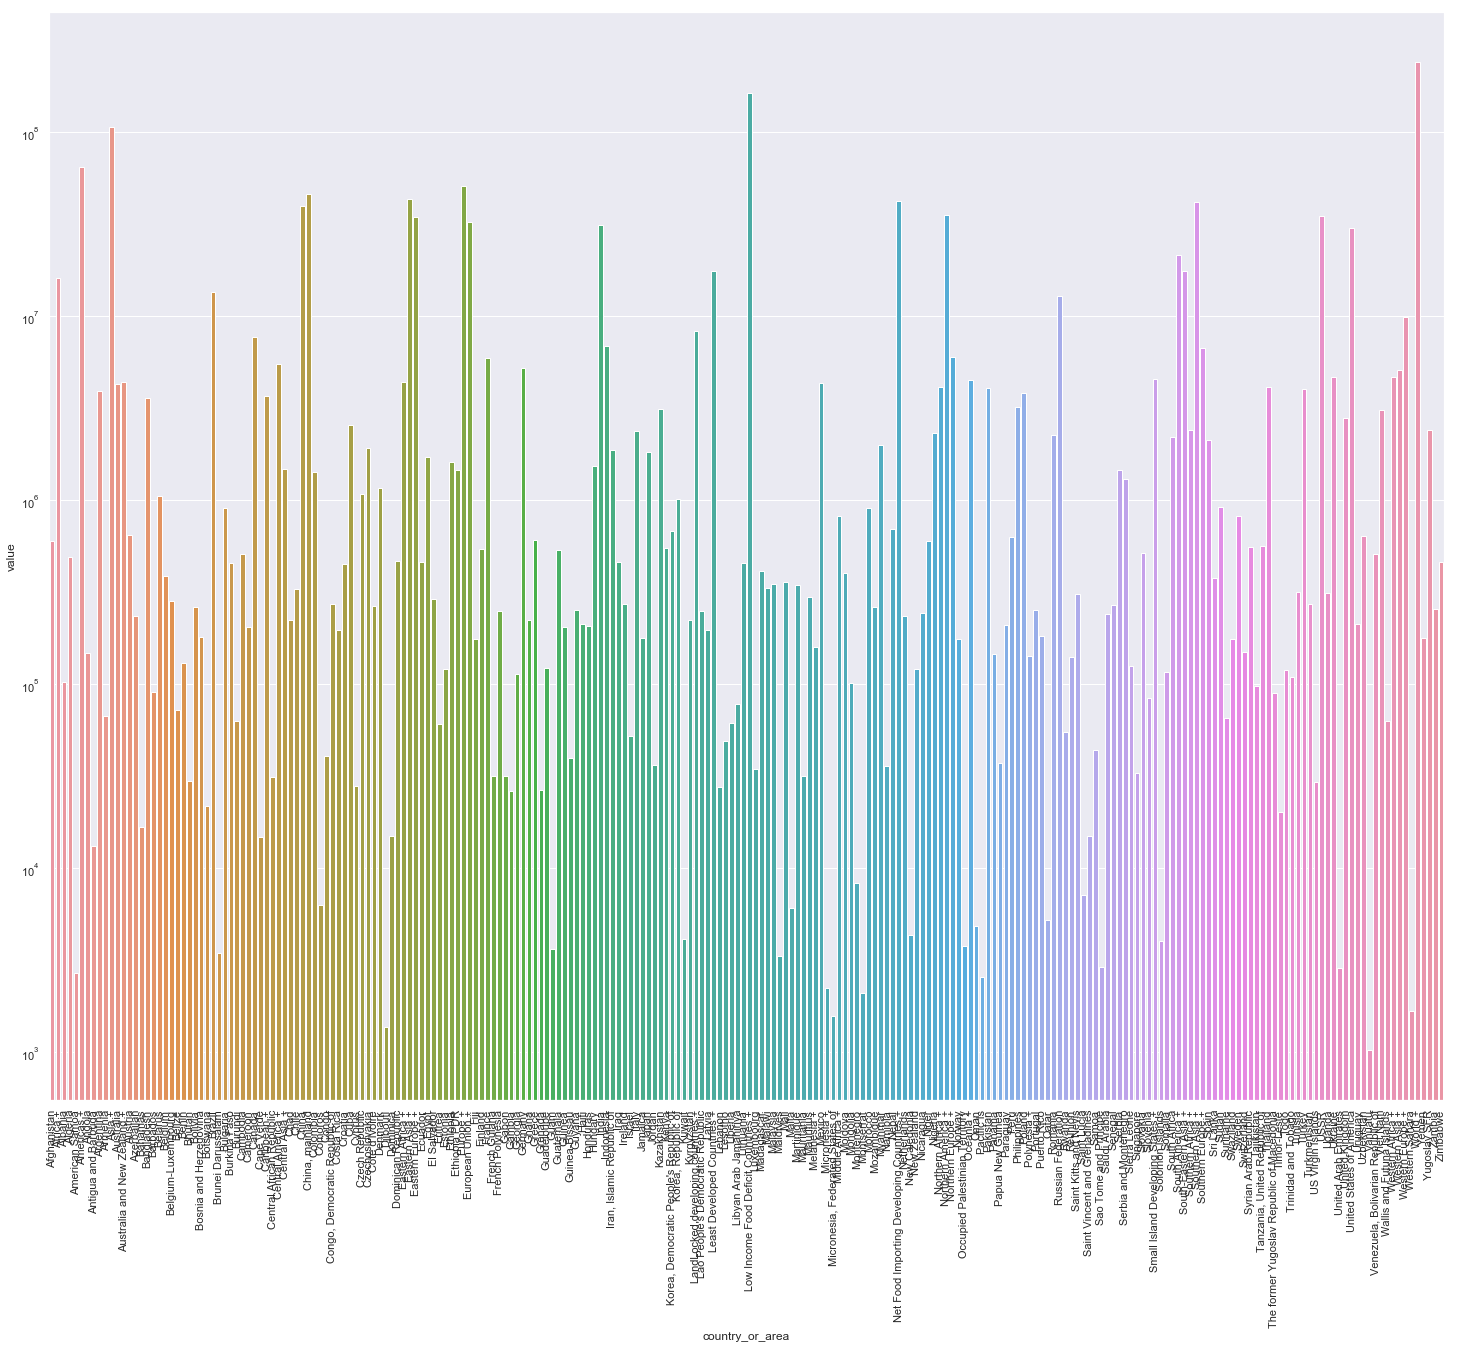

In [32]:
country_graph = sns.barplot(x=cou.index, y=cou.value)
country_graph.set(yscale='log')
plt.xticks(rotation=90)

#### Creating a graph to show the change in value output of wheat over time in Western Europe.

In [33]:
WE = glob_polish[glob_polish["country_or_area"] == "Western Europe +"]

In [34]:
cou = glob_polish.groupby('year')['value'].mean()

In [35]:
WE = WE[WE["category"] == "wheat"]

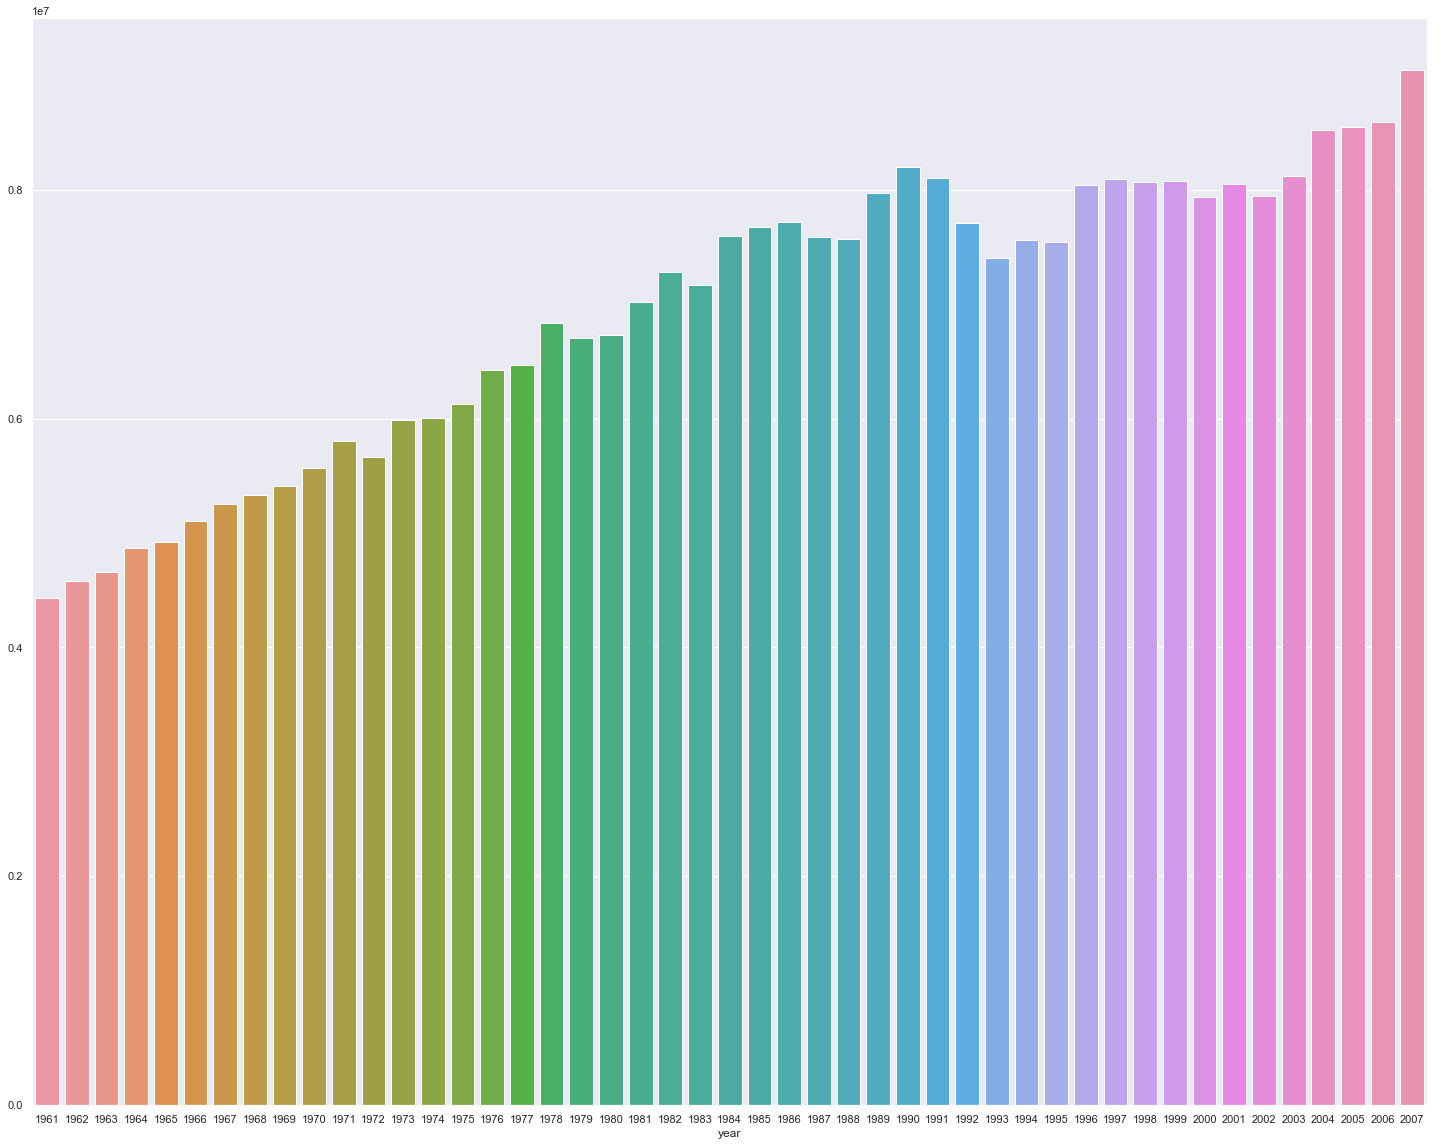

In [36]:

sns.barplot(x=cou.index, y=cou.values)
plt.show()

#### Time to dumify the countries and crops

In [37]:
glob_dummy = pd.get_dummies(glob_polish, drop_first=True)

In [38]:
glob_dummy.head()

year     value  country_or_area_Africa +  country_or_area_Albania  \
364493  2007  226250.0                         0                        0   
364494  2006  251495.0                         0                        0   
364495  2005  248575.0                         0                        0   
364496  2004  245015.0                         0                        0   
364497  2003  215475.0                         0                        0   

        country_or_area_Algeria  country_or_area_American Samoa  \
364493                        0                               0   
364494                        0                               0   
364495                        0                               0   
364496                        0                               0   
364497                        0                               0   

        country_or_area_Americas +  country_or_area_Angola  \
364493                           0                       0   
364494                           0                       0   
364495                           0                       0   
364496                           0                       0   
364497                           0                       0   

        country_or_area_Antigua and Barbuda  country_or_area_Argentina  \
364493                                    0                          0   
364494                                    0                          0   
364495                                    0                          0   
364496                                    0                          0   
364497                                    0                          0   

             ...        country_or_area_Western Sahara  \
364493       ...                                     0   
364494       ...                                     0   
364495       ...                                     0   
364496       ...                                     0   
364497       ...                                     0   

        country_or_area_World +  country_or_area_Yemen  \
364493                        0                      0   
364494                        0                      0   
364495                        0                      0   
364496                        0                      0   
364497                        0                      0   

        country_or_area_Yugoslav SFR  country_or_area_Zambia  \
364493                             0                       0   
364494                             0                       0   
364495                             0                       0   
364496                             0                       0   
364497                             0                       0   

        country_or_area_Zimbabwe  category_coarse_grain_total  \
364493                         0                            0   
364494                         0                            0   
364495                         0                            0   
364496                         0                            0   
364497                         0                            0   

        category_rice_paddy  category_sugar_cane  category_wheat  
364493                    0                    0               0  
364494                    0                    0               0  
364495                    0                    0               0  
364496                    0                    0               0  
364497                    0                    0               0  

[5 rows x 239 columns]

In [39]:
glob_dict

Unnamed: 0                                         Unnamed: 1
0  Country_or_area  Contains the names of each country that is inc...
1             Year  This states the year that the data was collect...
2             Unit  This states the unit of measurement that the c...
3            Value  This states the quantity of the crop harvested...
4         Category  This states the type of crop harvested. This r...

#### Running a Linear Regression after doing a train test split to the dataset.

In [40]:
scaler = StandardScaler()

In [41]:
model = LinearRegression()

The predictors are the dummified countries, crops and the year. Predicting the value output.

In [42]:
glob_X = glob_dummy
glob_y= glob_dummy.pop('value')

In [43]:
glob_X.drop('country_or_area_World +', axis = True, inplace=True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(glob_X, glob_y, test_size=0.33)

In [45]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=glob_X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=glob_X.columns)

#### Creating a function to save time on the regression models

In [46]:
def get_model_scores(model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validated training scores:", scores)
    print("Mean cross-validated training score:", scores.mean())
    model.fit(X_train, y_train)
    print("Training Score:", model.score(X_train, y_train))
    print("Test Score:", model.score(X_test, y_test))
    return model

In [47]:
get_model_scores(LinearRegression(), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.2037476  0.18215305 0.17551267 0.16882043 0.18567372]
Mean cross-validated training score: 0.1831814947159465
Training Score: 0.18485060143917353
Test Score: 0.1742835585048247


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Getting the coefficients of the predictors to determine how impactful they are.

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)
   

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [49]:
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

coefficients      coef_abs
year                                               1.494321e+06  1.494321e+06
country_or_area_Africa +                          -8.157048e+06  8.157048e+06
country_or_area_Albania                           -8.831500e+06  8.831500e+06
country_or_area_Algeria                           -8.629107e+06  8.629107e+06
country_or_area_American Samoa                    -3.158473e+06  3.158473e+06
country_or_area_Americas +                        -4.246423e+06  4.246423e+06
country_or_area_Angola                            -9.143395e+06  9.143395e+06
country_or_area_Antigua and Barbuda               -7.321868e+06  7.321868e+06
country_or_area_Argentina                         -8.865950e+06  8.865950e+06
country_or_area_Armenia                           -4.556748e+06  4.556748e+06
country_or_area_Asia +                            -2.090627e+06  2.090627e+06
country_or_area_Australia                         -8.926047e+06  8.926047e+06
country_or_area_Australia and New Zealand +       -8.943055e+06  8.943055e+06
country_or_area_Austria                           -7.852000e+06  7.852000e+06
country_or_area_Azerbaijan                        -5.235224e+06  5.235224e+06
country_or_area_Bahamas                           -7.803640e+06  7.803640e+06
country_or_area_Bangladesh                        -9.036350e+06  9.036350e+06
country_or_area_Barbados                          -7.772453e+06  7.772453e+06
country_or_area_Belarus                           -4.581203e+06  4.581203e+06
country_or_area_Belgium                           -3.529264e+06  3.529264e+06
country_or_area_Belgium-Luxembourg                -7.644086e+06  7.644086e+06
country_or_area_Belize                            -8.461267e+06  8.461267e+06
country_or_area_Benin                             -8.667501e+06  8.667501e+06
country_or_area_Bhutan                            -9.119180e+06  9.119180e+06
country_or_area_Bolivia                           -9.206789e+06  9.206789e+06
country_or_area_Bosnia and Herzegovina            -4.634595e+06  4.634595e+06
country_or_area_Botswana                          -7.705506e+06  7.705506e+06
country_or_area_Brazil                            -8.195780e+06  8.195780e+06
country_or_area_Brunei Darussalam                 -6.973949e+06  6.973949e+06
country_or_area_Bulgaria                          -8.768020e+06  8.768020e+06
...                                                         ...           ...
country_or_area_Togo                              -7.904248e+06  7.904248e+06
country_or_area_Trinidad and Tobago               -8.602395e+06  8.602395e+06
country_or_area_Tunisia                           -7.893805e+06  7.893805e+06
country_or_area_Turkey                            -8.447210e+06  8.447210e+06
country_or_area_Turkmenistan                      -5.093274e+06  5.093274e+06
country_or_area_US Virgin Islands                 -3.207238e+06  3.207238e+06
country_or_area_USSR                              -4.557194e+06  4.557194e+06
country_or_area_Uganda                            -9.254513e+06  9.254513e+06
country_or_area_Ukraine                           -4.977095e+06  4.977095e+06
country_or_area_United Arab Emirates              -6.447912e+06  6.447912e+06
country_or_area_United Kingdom                    -7.624686e+06  7.624686e+06
country_or_area_United States of America          -7.207670e+06  7.207670e+06
country_or_area_Uruguay                           -9.168316e+06  9.168316e+06
country_or_area_Uzbekistan                        -5.094282e+06  5.094282e+06
country_or_area_Vanuatu                           -7.089418e+06  7.089418e+06
country_or_area_Venezuela, Bolivarian Republic of -9.294646e+06  9.294646e+06
country_or_area_Viet Nam                          -8.536630e+06  8.536630e+06
country_or_area_Wallis and Futuna Islands         -3.293026e+06  3.293026e+06
country_or_area_Western Africa +                  -8.996173e+06  8.996173e+06
country_or_area_Western Asia +                    -8.947550e+06  8.947550

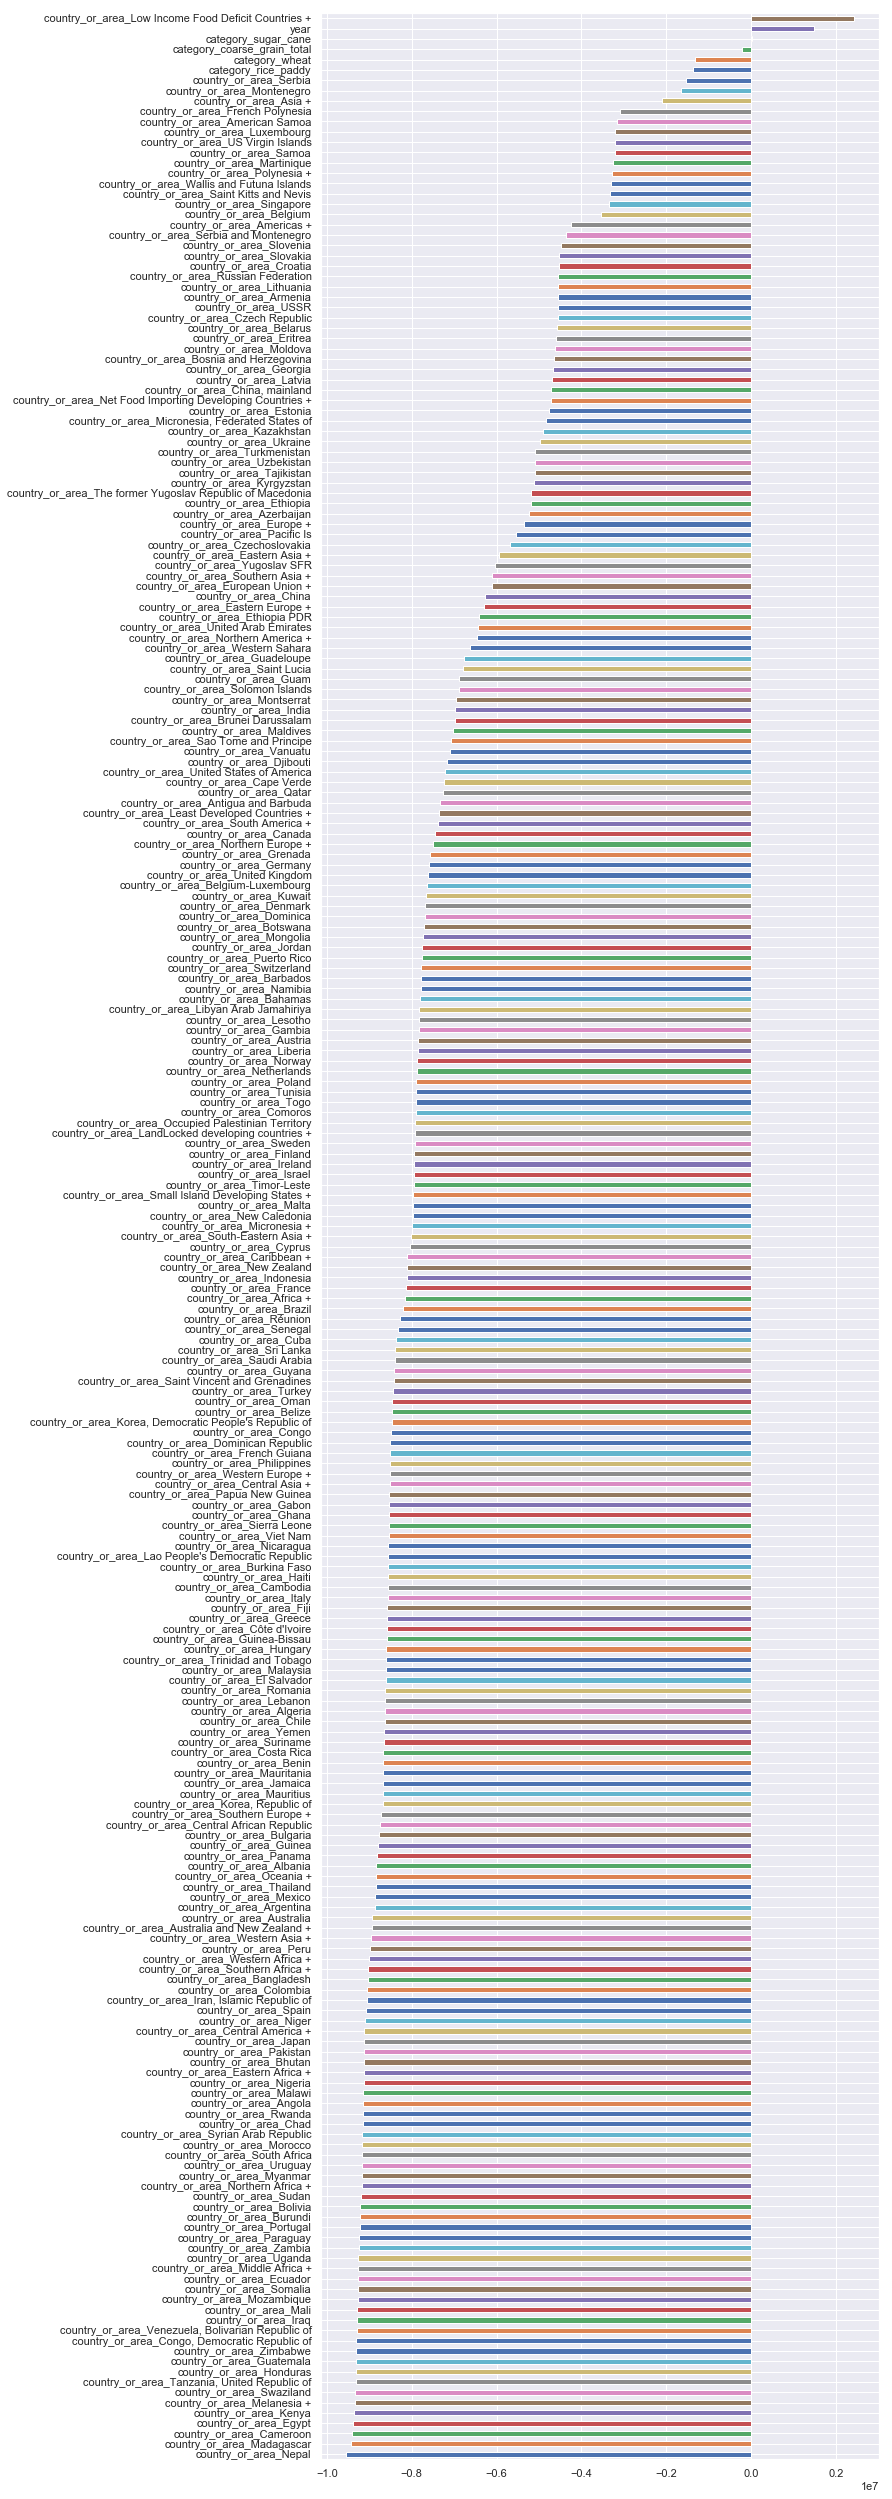

In [50]:
plt.figure(figsize=(10,45))

df_coef['coefficients'].sort_values().plot(kind='barh');

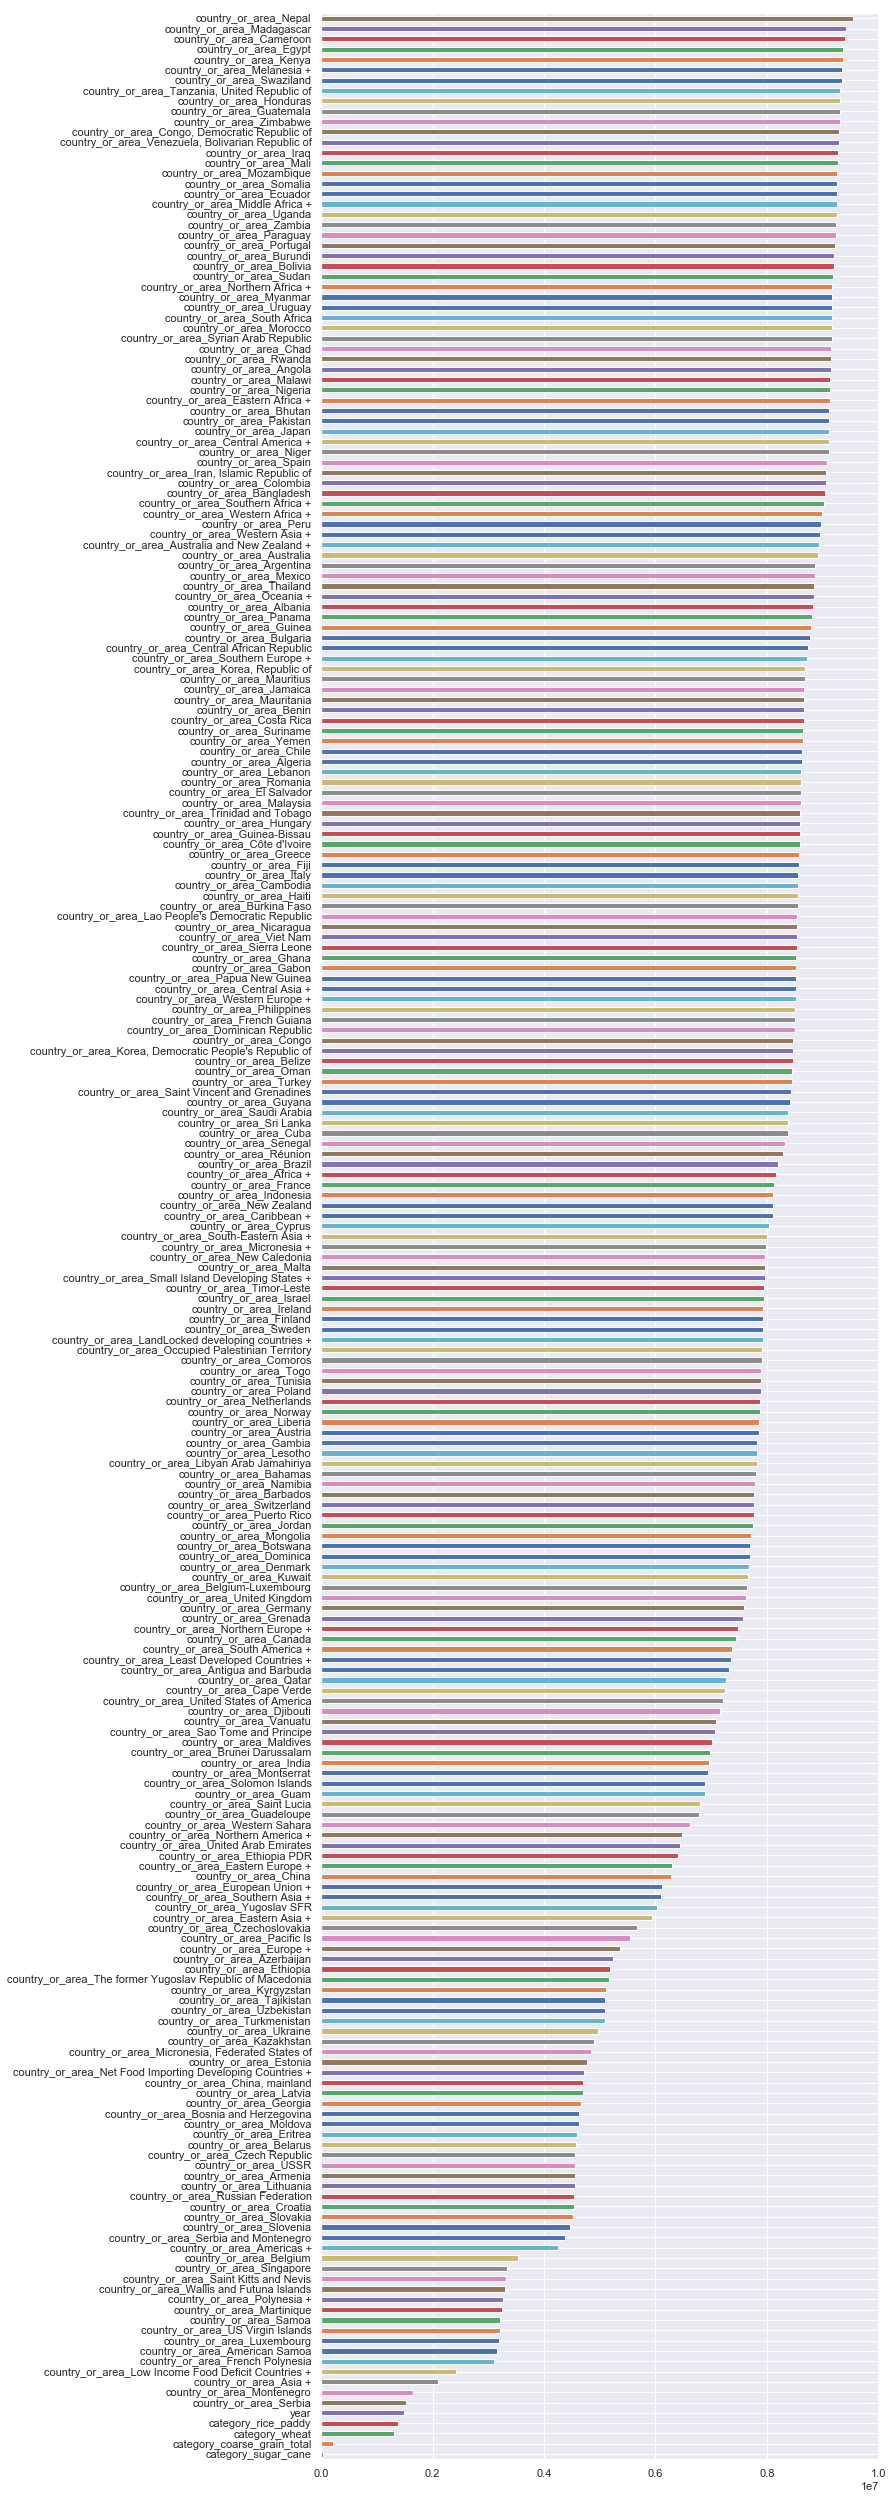

In [51]:
plt.figure(figsize=(10,45))

df_coef['coef_abs'].sort_values().plot(kind='barh');

#### Repeat the process with a RidgeCV, LassoCV and an ElasticCV

In [52]:
get_model_scores(RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.20372712 0.182135   0.17559435 0.16877947 0.18584698]
Mean cross-validated training score: 0.18321658455577483
Training Score: 0.18483844057149534
Test Score: 0.17423887520639791


RidgeCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [53]:
model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)
   

RidgeCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [54]:
df_coef1 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef1['coef_abs'] = df_coef1.coefficients.abs()
df_coef1

coefficients      coef_abs
year                                               1.493333e+06  1.493333e+06
country_or_area_Africa +                          -8.038487e+06  8.038487e+06
country_or_area_Albania                           -8.720175e+06  8.720175e+06
country_or_area_Algeria                           -8.519965e+06  8.519965e+06
country_or_area_American Samoa                    -3.119395e+06  3.119395e+06
country_or_area_Americas +                        -4.127633e+06  4.127633e+06
country_or_area_Angola                            -9.028419e+06  9.028419e+06
country_or_area_Antigua and Barbuda               -7.230647e+06  7.230647e+06
country_or_area_Argentina                         -8.750872e+06  8.750872e+06
country_or_area_Armenia                           -4.500274e+06  4.500274e+06
country_or_area_Asia +                            -1.971544e+06  1.971544e+06
country_or_area_Australia                         -8.809726e+06  8.809726e+06
country_or_area_Australia and New Zealand +       -8.826652e+06  8.826652e+06
country_or_area_Austria                           -7.753009e+06  7.753009e+06
country_or_area_Azerbaijan                        -5.169982e+06  5.169982e+06
country_or_area_Bahamas                           -7.706392e+06  7.706392e+06
country_or_area_Bangladesh                        -8.919214e+06  8.919214e+06
country_or_area_Barbados                          -7.675560e+06  7.675560e+06
country_or_area_Belarus                           -4.523973e+06  4.523973e+06
country_or_area_Belgium                           -3.485573e+06  3.485573e+06
country_or_area_Belgium-Luxembourg                -7.547821e+06  7.547821e+06
country_or_area_Belize                            -8.355213e+06  8.355213e+06
country_or_area_Benin                             -8.558816e+06  8.558816e+06
country_or_area_Bhutan                            -9.004640e+06  9.004640e+06
country_or_area_Bolivia                           -9.090860e+06  9.090860e+06
country_or_area_Bosnia and Herzegovina            -4.577071e+06  4.577071e+06
country_or_area_Botswana                          -7.608877e+06  7.608877e+06
country_or_area_Brazil                            -8.077917e+06  8.077917e+06
country_or_area_Brunei Darussalam                 -6.886374e+06  6.886374e+06
country_or_area_Bulgaria                          -8.656858e+06  8.656858e+06
...                                                         ...           ...
country_or_area_Togo                              -7.804901e+06  7.804901e+06
country_or_area_Trinidad and Tobago               -8.494573e+06  8.494573e+06
country_or_area_Tunisia                           -7.794557e+06  7.794557e+06
country_or_area_Turkey                            -8.337089e+06  8.337089e+06
country_or_area_Turkmenistan                      -5.029779e+06  5.029779e+06
country_or_area_US Virgin Islands                 -3.167510e+06  3.167510e+06
country_or_area_USSR                              -4.476372e+06  4.476372e+06
country_or_area_Uganda                            -9.137982e+06  9.137982e+06
country_or_area_Ukraine                           -4.912559e+06  4.912559e+06
country_or_area_United Arab Emirates              -6.366991e+06  6.366991e+06
country_or_area_United Kingdom                    -7.526765e+06  7.526765e+06
country_or_area_United States of America          -7.088556e+06  7.088556e+06
country_or_area_Uruguay                           -9.052822e+06  9.052822e+06
country_or_area_Uzbekistan                        -5.030651e+06  5.030651e+06
country_or_area_Vanuatu                           -7.000974e+06  7.000974e+06
country_or_area_Venezuela, Bolivarian Republic of -9.177394e+06  9.177394e+06
country_or_area_Viet Nam                          -8.426978e+06  8.426978e+06
country_or_area_Wallis and Futuna Islands         -3.252234e+06  3.252234e+06
country_or_area_Western Africa +                  -8.878555e+06  8.878555e+06
country_or_area_Western Asia +                    -8.830215e+06  8.830215

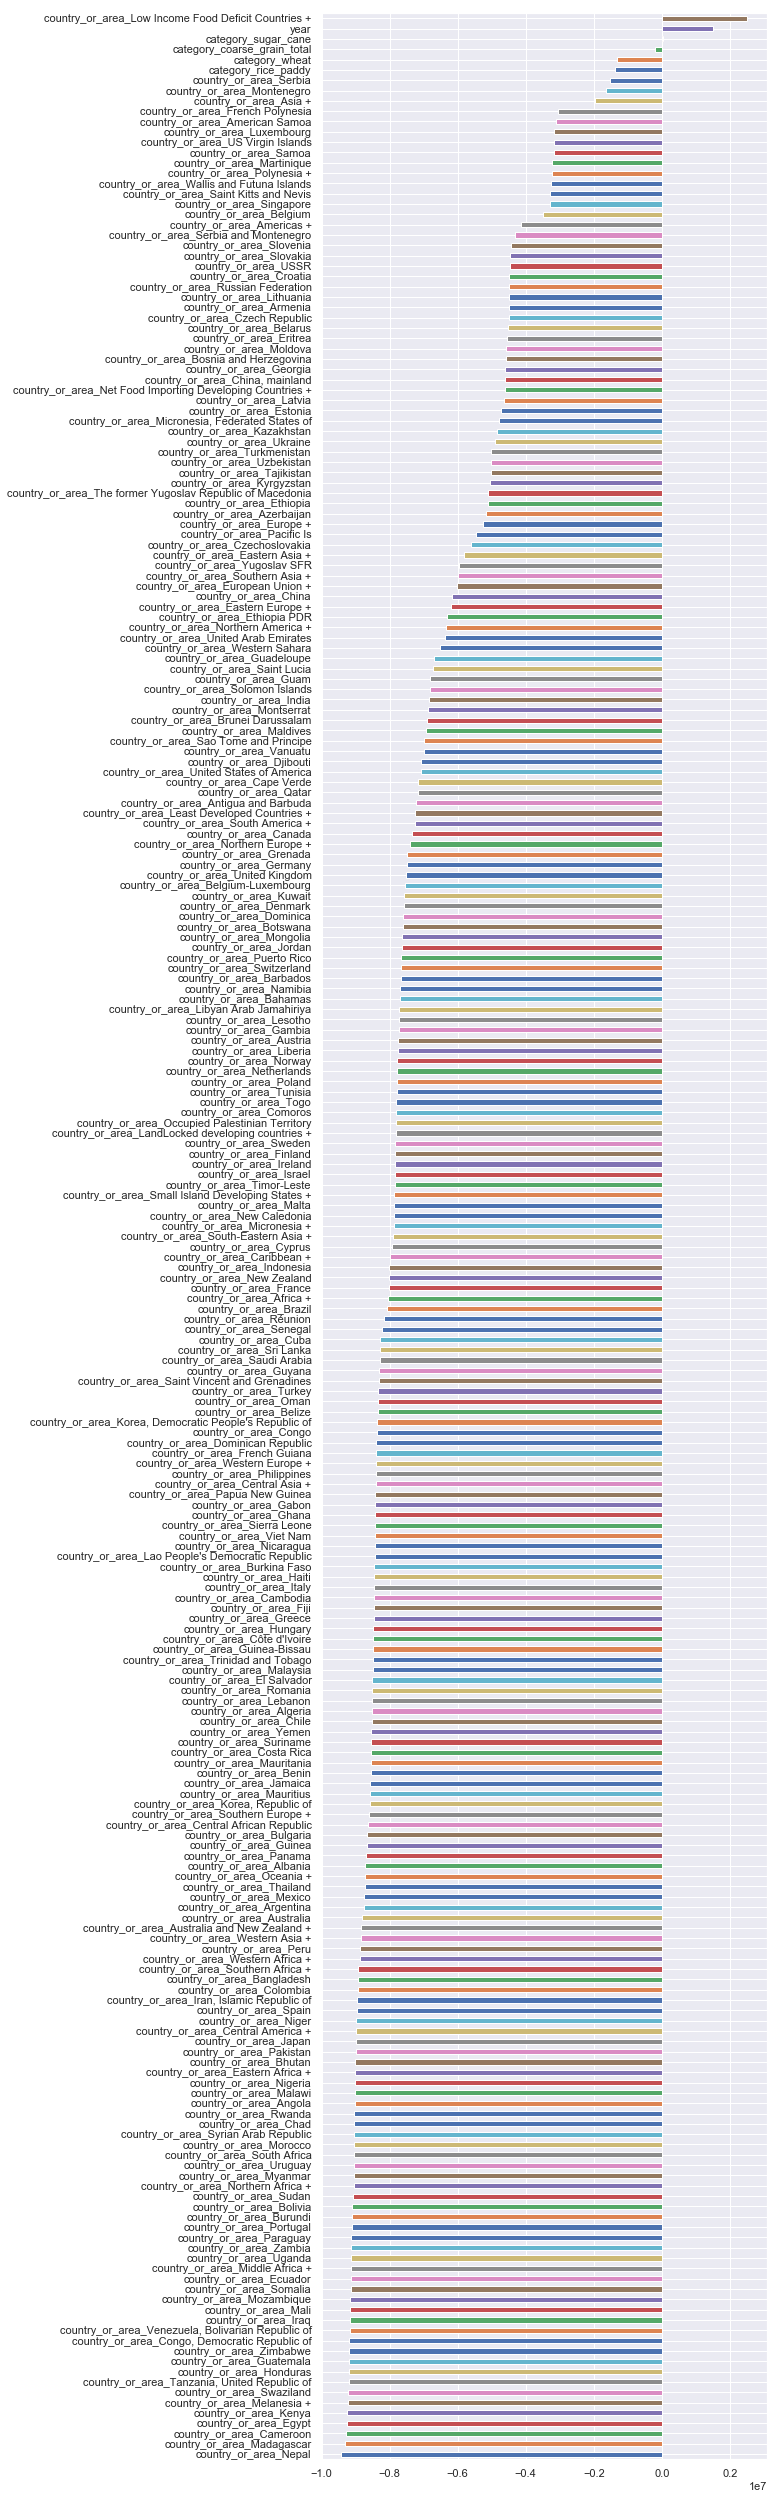

In [102]:
plt.figure(figsize=(8,45))

df_coef1['coefficients'].sort_values().plot(kind='barh');

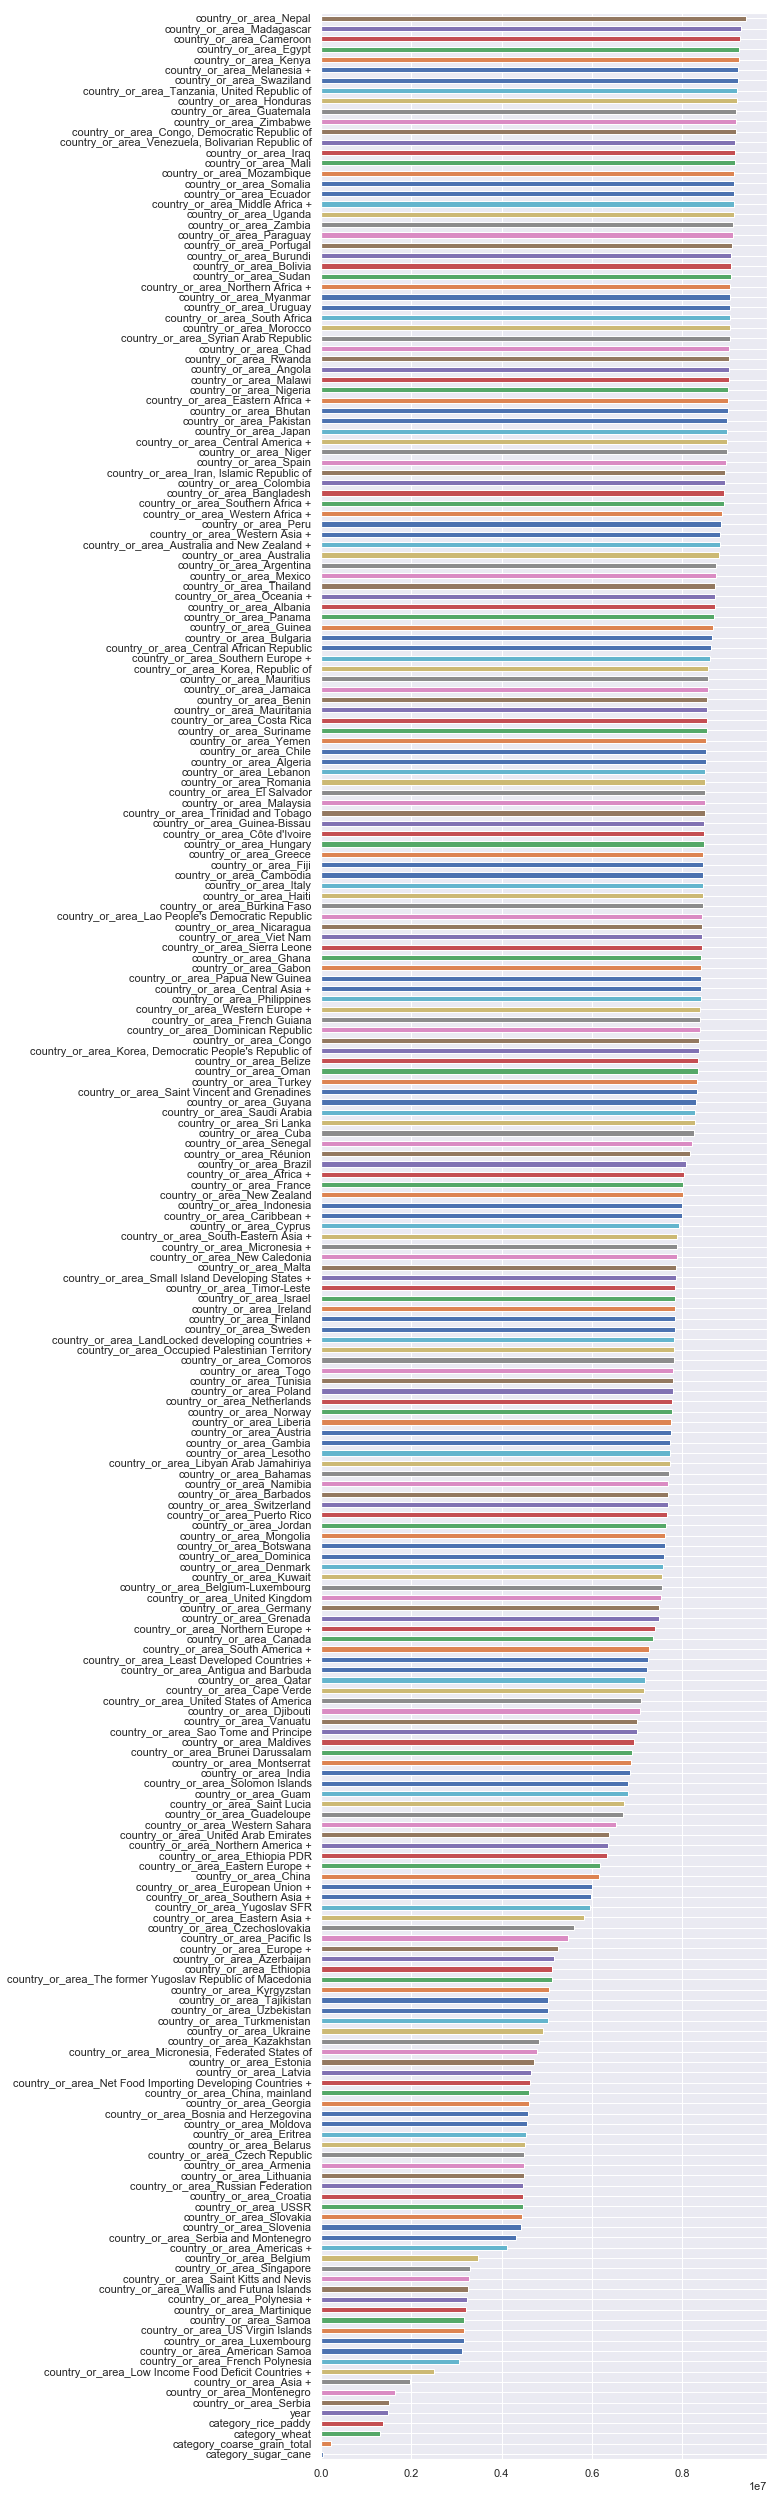

In [101]:
plt.figure(figsize=(8,45))

df_coef1['coef_abs'].sort_values().plot(kind='barh');

#### LassoCV

In [57]:
get_model_scores(LassoCV(alphas=np.logspace(-4, 4, 10), cv=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.2037476  0.18215305 0.17551378 0.16882043 0.18567372]
Mean cross-validated training score: 0.1831817173531505
Training Score: 0.18485060143917365
Test Score: 0.17428355850193167


LassoCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [58]:
model = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)

LassoCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [59]:
df_coef2 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef2['coef_abs'] = df_coef2.coefficients.abs()
df_coef2

coefficients      coef_abs
year                                               1.494321e+06  1.494321e+06
country_or_area_Africa +                          -8.157048e+06  8.157048e+06
country_or_area_Albania                           -8.831500e+06  8.831500e+06
country_or_area_Algeria                           -8.629107e+06  8.629107e+06
country_or_area_American Samoa                    -3.158473e+06  3.158473e+06
country_or_area_Americas +                        -4.246423e+06  4.246423e+06
country_or_area_Angola                            -9.143395e+06  9.143395e+06
country_or_area_Antigua and Barbuda               -7.321868e+06  7.321868e+06
country_or_area_Argentina                         -8.865950e+06  8.865950e+06
country_or_area_Armenia                           -4.556748e+06  4.556748e+06
country_or_area_Asia +                            -2.090627e+06  2.090627e+06
country_or_area_Australia                         -8.926047e+06  8.926047e+06
country_or_area_Australia and New Zealand +       -8.943055e+06  8.943055e+06
country_or_area_Austria                           -7.852000e+06  7.852000e+06
country_or_area_Azerbaijan                        -5.235224e+06  5.235224e+06
country_or_area_Bahamas                           -7.803640e+06  7.803640e+06
country_or_area_Bangladesh                        -9.036350e+06  9.036350e+06
country_or_area_Barbados                          -7.772453e+06  7.772453e+06
country_or_area_Belarus                           -4.581203e+06  4.581203e+06
country_or_area_Belgium                           -3.529264e+06  3.529264e+06
country_or_area_Belgium-Luxembourg                -7.644086e+06  7.644086e+06
country_or_area_Belize                            -8.461267e+06  8.461267e+06
country_or_area_Benin                             -8.667501e+06  8.667501e+06
country_or_area_Bhutan                            -9.119180e+06  9.119180e+06
country_or_area_Bolivia                           -9.206789e+06  9.206789e+06
country_or_area_Bosnia and Herzegovina            -4.634595e+06  4.634595e+06
country_or_area_Botswana                          -7.705506e+06  7.705506e+06
country_or_area_Brazil                            -8.195780e+06  8.195780e+06
country_or_area_Brunei Darussalam                 -6.973949e+06  6.973949e+06
country_or_area_Bulgaria                          -8.768020e+06  8.768020e+06
...                                                         ...           ...
country_or_area_Togo                              -7.904248e+06  7.904248e+06
country_or_area_Trinidad and Tobago               -8.602395e+06  8.602395e+06
country_or_area_Tunisia                           -7.893805e+06  7.893805e+06
country_or_area_Turkey                            -8.447210e+06  8.447210e+06
country_or_area_Turkmenistan                      -5.093274e+06  5.093274e+06
country_or_area_US Virgin Islands                 -3.207238e+06  3.207238e+06
country_or_area_USSR                              -4.557194e+06  4.557194e+06
country_or_area_Uganda                            -9.254513e+06  9.254513e+06
country_or_area_Ukraine                           -4.977095e+06  4.977095e+06
country_or_area_United Arab Emirates              -6.447912e+06  6.447912e+06
country_or_area_United Kingdom                    -7.624686e+06  7.624686e+06
country_or_area_United States of America          -7.207670e+06  7.207670e+06
country_or_area_Uruguay                           -9.168316e+06  9.168316e+06
country_or_area_Uzbekistan                        -5.094282e+06  5.094282e+06
country_or_area_Vanuatu                           -7.089418e+06  7.089418e+06
country_or_area_Venezuela, Bolivarian Republic of -9.294646e+06  9.294646e+06
country_or_area_Viet Nam                          -8.536630e+06  8.536630e+06
country_or_area_Wallis and Futuna Islands         -3.293026e+06  3.293026e+06
country_or_area_Western Africa +                  -8.996173e+06  8.996173e+06
country_or_area_Western Asia +                    -8.947550e+06  8.947550

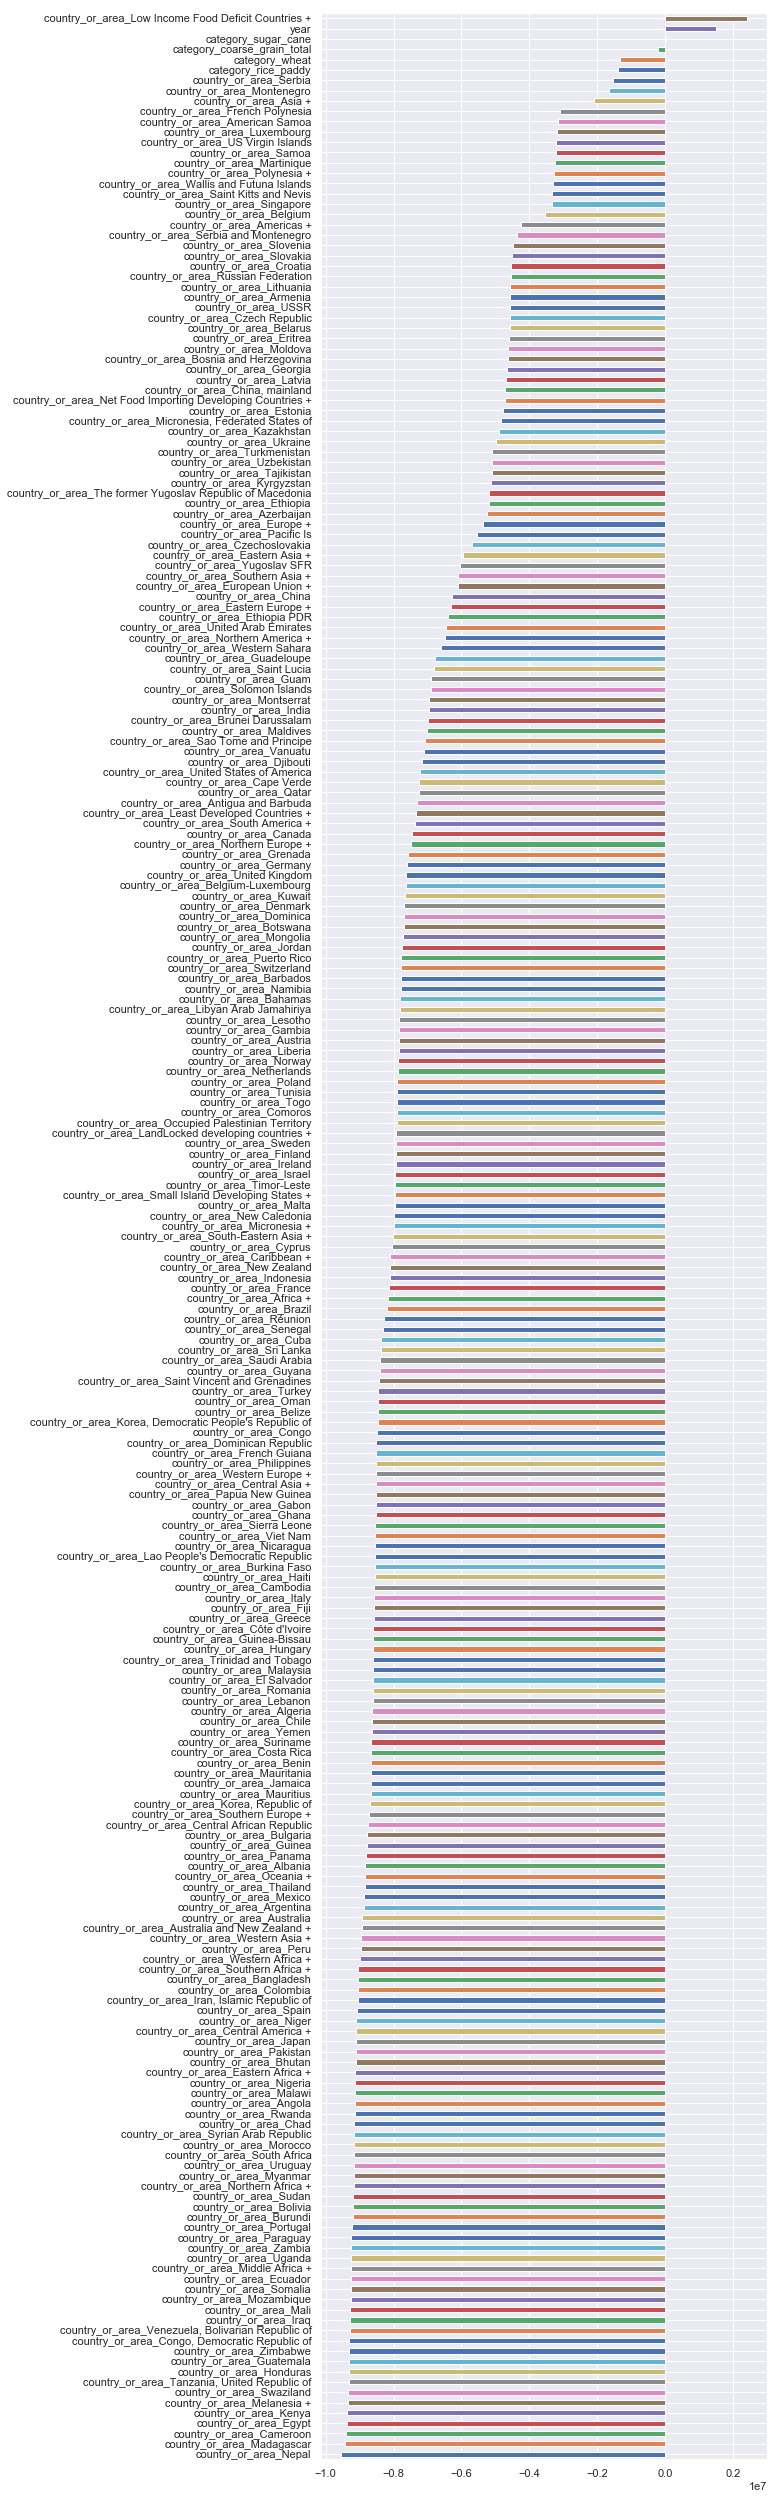

In [103]:
plt.figure(figsize=(8,45))

df_coef2['coefficients'].sort_values().plot(kind='barh');

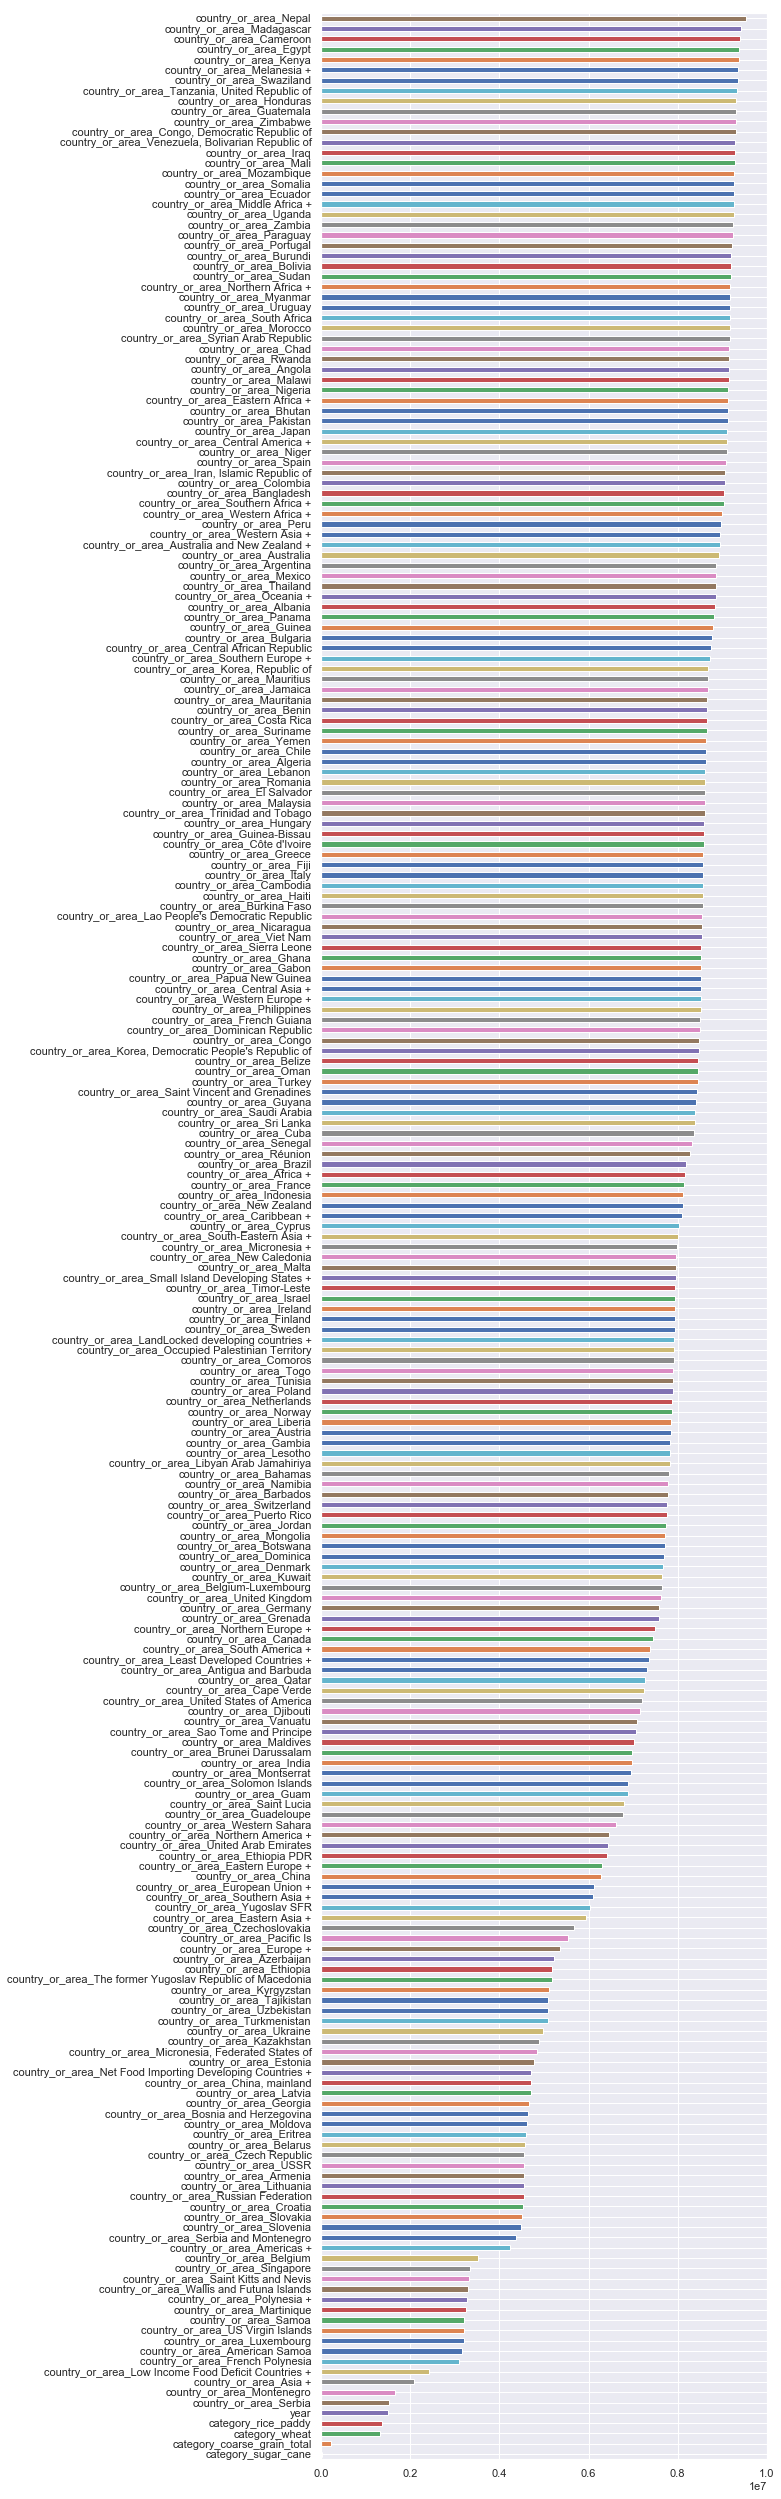

In [106]:
plt.figure(figsize=(8,45))

df_coef2['coef_abs'].sort_values().plot(kind='barh');

#### ElasticNetCV

In [62]:
get_model_scores(elastic, X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.20370658 0.18211695 0.17567287 0.16873912 0.18572217]
Mean cross-validated training score: 0.183191539192297
Training Score: 0.18484934160568212
Test Score: 0.174271541401686


ElasticNetCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [63]:
model = elastic
model.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [64]:
df_coef3 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef3['coef_abs'] = df_coef3.coefficients.abs()
df_coef3

coefficients      coef_abs
year                                               1.494004e+06  1.494004e+06
country_or_area_Africa +                          -8.118887e+06  8.118887e+06
country_or_area_Albania                           -8.795668e+06  8.795668e+06
country_or_area_Algeria                           -8.593978e+06  8.593978e+06
country_or_area_American Samoa                    -3.145895e+06  3.145895e+06
country_or_area_Americas +                        -4.208186e+06  4.208186e+06
country_or_area_Angola                            -9.106388e+06  9.106388e+06
country_or_area_Antigua and Barbuda               -7.292507e+06  7.292507e+06
country_or_area_Argentina                         -8.828910e+06  8.828910e+06
country_or_area_Armenia                           -4.538571e+06  4.538571e+06
country_or_area_Asia +                            -2.052295e+06  2.052295e+06
country_or_area_Australia                         -8.888607e+06  8.888607e+06
country_or_area_Australia and New Zealand +       -8.905589e+06  8.905589e+06
country_or_area_Austria                           -7.820139e+06  7.820139e+06
country_or_area_Azerbaijan                        -5.214225e+06  5.214225e+06
country_or_area_Bahamas                           -7.772339e+06  7.772339e+06
country_or_area_Bangladesh                        -8.998648e+06  8.998648e+06
country_or_area_Barbados                          -7.741267e+06  7.741267e+06
country_or_area_Belarus                           -4.562783e+06  4.562783e+06
country_or_area_Belgium                           -3.515202e+06  3.515202e+06
country_or_area_Belgium-Luxembourg                -7.613101e+06  7.613101e+06
country_or_area_Belize                            -8.427132e+06  8.427132e+06
country_or_area_Benin                             -8.632519e+06  8.632519e+06
country_or_area_Bhutan                            -9.082314e+06  9.082314e+06
country_or_area_Bolivia                           -9.169476e+06  9.169476e+06
country_or_area_Bosnia and Herzegovina            -4.616080e+06  4.616080e+06
country_or_area_Botswana                          -7.674405e+06  7.674405e+06
country_or_area_Brazil                            -8.157844e+06  8.157844e+06
country_or_area_Brunei Darussalam                 -6.945762e+06  6.945762e+06
country_or_area_Bulgaria                          -8.732241e+06  8.732241e+06
...                                                         ...           ...
country_or_area_Togo                              -7.872272e+06  7.872272e+06
country_or_area_Trinidad and Tobago               -8.567691e+06  8.567691e+06
country_or_area_Tunisia                           -7.861860e+06  7.861860e+06
country_or_area_Turkey                            -8.411766e+06  8.411766e+06
country_or_area_Turkmenistan                      -5.072837e+06  5.072837e+06
country_or_area_US Virgin Islands                 -3.194451e+06  3.194451e+06
country_or_area_USSR                              -4.531179e+06  4.531179e+06
country_or_area_Uganda                            -9.217006e+06  9.217006e+06
country_or_area_Ukraine                           -4.956323e+06  4.956323e+06
country_or_area_United Arab Emirates              -6.421866e+06  6.421866e+06
country_or_area_United Kingdom                    -7.593169e+06  7.593169e+06
country_or_area_United States of America          -7.169330e+06  7.169330e+06
country_or_area_Uruguay                           -9.131142e+06  9.131142e+06
country_or_area_Uzbekistan                        -5.073802e+06  5.073802e+06
country_or_area_Vanuatu                           -7.060951e+06  7.060951e+06
country_or_area_Venezuela, Bolivarian Republic of -9.256907e+06  9.256907e+06
country_or_area_Viet Nam                          -8.501337e+06  8.501337e+06
country_or_area_Wallis and Futuna Islands         -3.279897e+06  3.279897e+06
country_or_area_Western Africa +                  -8.958316e+06  8.958316e+06
country_or_area_Western Asia +                    -8.909784e+06  8.909784

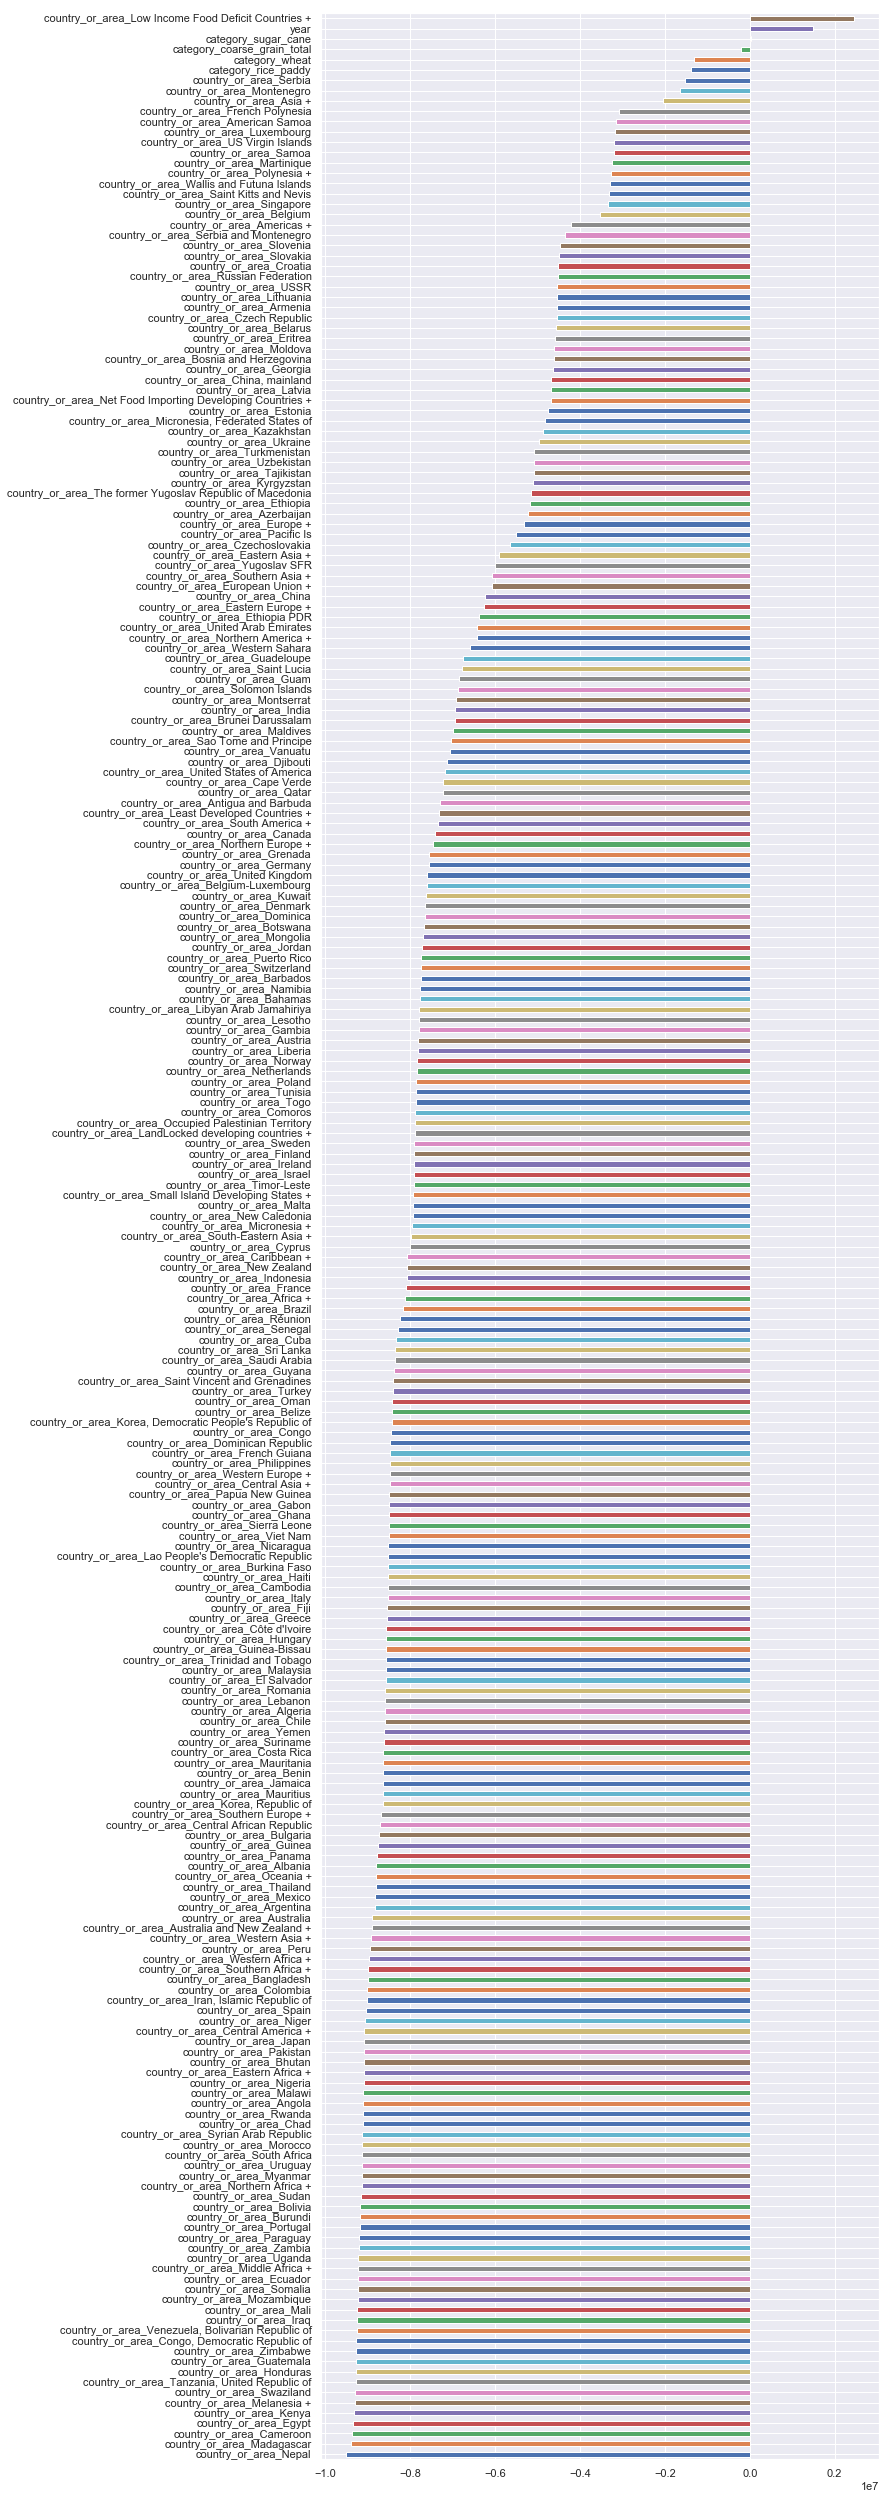

In [65]:
plt.figure(figsize=(10,45))

df_coef3['coefficients'].sort_values().plot(kind='barh');

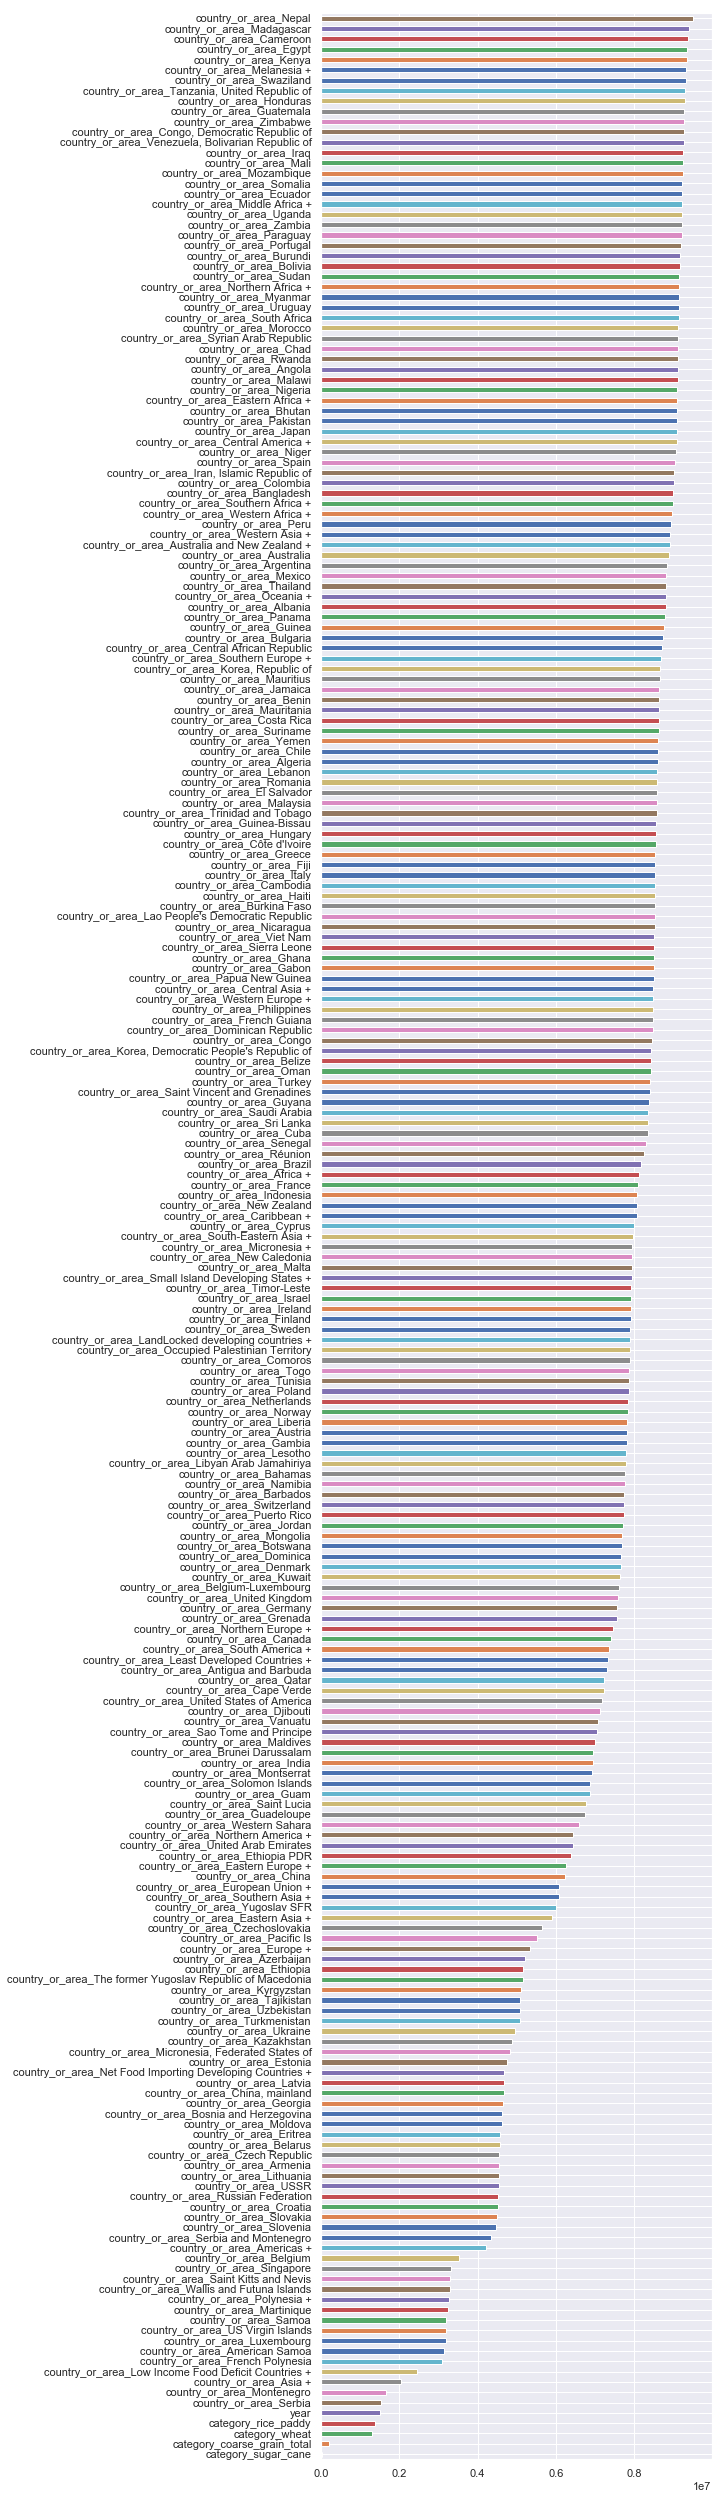

In [107]:
plt.figure(figsize=(7,45))
df_coef3['coef_abs'].sort_values().plot(kind='barh');

### decision tree regression and random forest regression

In [67]:
dt = DecisionTreeRegressor(max_depth=5, criterion='mse')

In [68]:
get_model_scores(DecisionTreeRegressor(max_depth=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.08818364 0.08500445 0.07643469 0.06397993 0.09027466]
Mean cross-validated training score: 0.08077547410245708
Training Score: 0.09451517217124561
Test Score: 0.0918313180817747


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [69]:
def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO() 
    export_graphviz(dt, 
                    out_file=dot_data,  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                   )  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png()) 

In [70]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Max depth: 5


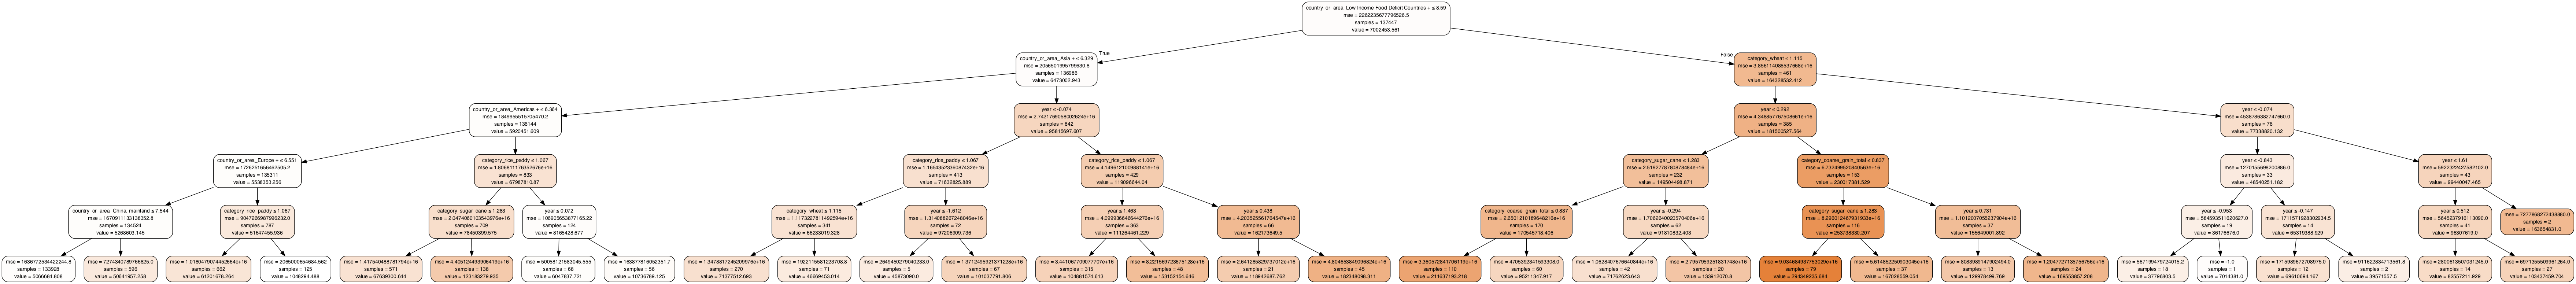

In [71]:
plot_dt(dt, feature_names=glob_X.columns)

In [72]:
kfolds = 5
model = DecisionTreeRegressor(random_state=1)

In [73]:
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          #, 'max_features':[1,2,3,4],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4]
          #'min_samples_split':[1,2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=kfolds, n_jobs = -1)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 test: ', gs.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=9, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R2 training:  0.08774336645274106
R2 test:  0.08929678410633302


In [74]:
gs_mse = GridSearchCV(model, param_grid=params, cv=kfolds,
                      scoring='neg_mean_squared_error')
gs_mse.fit(X_train, y_train)

print(gs_mse.best_estimator_)
print('MSE training: ', -gs_mse.score(X_train, y_train))
print('MSE test: ', -gs_mse.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=9, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
MSE training:  2063739503717576.2
MSE test:  2293089512330977.0


In [110]:
df_coef = pd.DataFrame(dt.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef.sort_values('feature importances', ascending=False)

feature importances
country_or_area_Low Income Food Deficit Countri...             0.389571
country_or_area_Asia +                                         0.230109
country_or_area_Americas +                                     0.109866
country_or_area_Europe +                                       0.057267
year                                                           0.046856
country_or_area_China, mainland                                0.041937
category_rice_paddy                                            0.037553
category_sugar_cane                                            0.035150
category_coarse_grain_total                                    0.027091
category_wheat                                                 0.024600
country_or_area_Armenia                                        0.000000
country_or_area_Serbia and Montenegro                          0.000000
country_or_area_Oceania +                                      0.000000
country_or_area_Oman                                           0.000000
country_or_area_Pacific Is                                     0.000000
country_or_area_Pakistan                                       0.000000
country_or_area_Panama                                         0.000000
country_or_area_Papua New Guinea                               0.000000
country_or_area_Paraguay                                       0.000000
country_or_area_Peru                                           0.000000
country_or_area_Philippines                                    0.000000
country_or_area_Poland                                         0.000000
country_or_area_Polynesia +                                    0.000000
country_or_area_Portugal                                       0.000000
country_or_area_Puerto Rico                                    0.000000
country_or_area_Qatar                                          0.000000
country_or_area_Romania                                        0.000000
country_or_area_Russian Federation                             0.000000
country_or_area_Rwanda                                         0.000000
country_or_area_Réunion                                        0.000000
...                                                                 ...
country_or_area_Malaysia                                       0.000000
country_or_area_Ireland                                        0.000000
country_or_area_Iraq                                           0.000000
country_or_area_Iran, Islamic Republic of                      0.000000
country_or_area_Ghana                                          0.000000
country_or_area_Antigua and Barbuda                            0.000000
country_or_area_European Union +                               0.000000
country_or_area_Fiji                                           0.000000
country_or_area_Finland                                        0.000000
country_or_area_France                                         0.000000
country_or_area_French Guiana                                  0.000000
country_or_area_French Polynesia                               0.000000
country_or_area_Gabon                                          0.000000
country_or_area_Gambia                                         0.000000
country_or_area_Georgia                                        0.000000
country_or_area_Germany                                        0.000000
country_or_area_Greece                                         0.000000
country_or_area_Indonesia                                      0.000000
country_or_area_Grenada                                        0.000000
country_or_area_Guadeloupe                                     0.000000
country_or_area_Guam                                           0.000000
country_or_area_Guatemala                                      0.000000
country_or_area_Guinea                                         0.000000
country_or_area_Guinea-Bissau                                  0.000000
country_or_area_Guya

In [109]:
df_coef = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef.sort_values('feature importances', ascending=False)

feature importances
year                                                           0.173872
country_or_area_Low Income Food Deficit Countri...             0.126385
country_or_area_Asia +                                         0.074652
category_sugar_cane                                            0.043159
category_rice_paddy                                            0.042299
country_or_area_Americas +                                     0.035643
category_coarse_grain_total                                    0.035357
category_wheat                                                 0.028307
country_or_area_Liberia                                        0.021150
country_or_area_Pacific Is                                     0.020482
country_or_area_Europe +                                       0.018579
country_or_area_Guadeloupe                                     0.018141
country_or_area_Solomon Islands                                0.017678
country_or_area_China, mainland                                0.013605
country_or_area_Southern Asia +                                0.012370
country_or_area_Eastern Asia +                                 0.012341
country_or_area_United Arab Emirates                           0.011536
country_or_area_China                                          0.010312
country_or_area_Northern America +                             0.009927
country_or_area_Saint Lucia                                    0.009863
country_or_area_Net Food Importing Developing C...             0.008028
country_or_area_Australia                                      0.007673
country_or_area_India                                          0.007053
country_or_area_Eastern Europe +                               0.007028
country_or_area_European Union +                               0.006332
country_or_area_United States of America                       0.006311
country_or_area_Eastern Africa +                               0.005873
country_or_area_Oceania +                                      0.005737
country_or_area_Yugoslav SFR                                   0.005721
country_or_area_Viet Nam                                       0.005359
...                                                                 ...
country_or_area_Germany                                        0.000157
country_or_area_Austria                                        0.000157
country_or_area_Gambia                                         0.000150
country_or_area_Estonia                                        0.000149
country_or_area_Bahamas                                        0.000147
country_or_area_Switzerland                                    0.000144
country_or_area_Polynesia +                                    0.000140
country_or_area_France                                         0.000131
country_or_area_Yemen                                          0.000125
country_or_area_Mongolia                                       0.000125
country_or_area_Guam                                           0.000125
country_or_area_Martinique                                     0.000113
country_or_area_Tunisia                                        0.000107
country_or_area_Albania                                        0.000106
country_or_area_Norway                                         0.000105
country_or_area_Northern Europe +                              0.000100
country_or_area_Samoa                                          0.000097
country_or_area_Ireland                                        0.000092
country_or_area_Maldives                                       0.000089
country_or_area_Singapore                                      0.000080
country_or_area_Sao Tome and Principe                          0.000077
country_or_area_Netherlands                                    0.000075
country_or_area_Mauritania                                     0.000068
country_or_area_Wallis and Futuna Islands                      0.000067
country_or_area_Jord

In [77]:
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=9, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [78]:
model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1183449 , 0.        , 0.        , 0.        , 0.        ,
       0.247868  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04517405, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04097571, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06168705,
       0.        , 0.        , 0.        , 0.        , 0.     

In [79]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
df_coef = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])


In [82]:
df_coef_ = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])

In [83]:
df_coef['coef_abs'] = df_coef_.coefficients.abs()


In [84]:
df_coef.sort_values('feature importances', ascending = False)

feature importances  \
year                                                           0.173872   
country_or_area_Low Income Food Deficit Countri...             0.126385   
country_or_area_Asia +                                         0.074652   
category_sugar_cane                                            0.043159   
category_rice_paddy                                            0.042299   
country_or_area_Americas +                                     0.035643   
category_coarse_grain_total                                    0.035357   
category_wheat                                                 0.028307   
country_or_area_Liberia                                        0.021150   
country_or_area_Pacific Is                                     0.020482   
country_or_area_Europe +                                       0.018579   
country_or_area_Guadeloupe                                     0.018141   
country_or_area_Solomon Islands                                0.017678   
country_or_area_China, mainland                                0.013605   
country_or_area_Southern Asia +                                0.012370   
country_or_area_Eastern Asia +                                 0.012341   
country_or_area_United Arab Emirates                           0.011536   
country_or_area_China                                          0.010312   
country_or_area_Northern America +                             0.009927   
country_or_area_Saint Lucia                                    0.009863   
country_or_area_Net Food Importing Developing C...             0.008028   
country_or_area_Australia                                      0.007673   
country_or_area_India                                          0.007053   
country_or_area_Eastern Europe +                               0.007028   
country_or_area_European Union +                               0.006332   
country_or_area_United States of America                       0.006311   
country_or_area_Eastern Africa +                               0.005873   
country_or_area_Oceania +                                      0.005737   
country_or_area_Yugoslav SFR                                   0.005721   
country_or_area_Viet Nam                                       0.005359   
...                                                                 ...   
country_or_area_Germany                                        0.000157   
country_or_area_Austria                                        0.000157   
country_or_area_Gambia                                         0.000150   
country_or_area_Estonia                                        0.000149   
country_or_area_Bahamas                                        0.000147   
country_or_area_Switzerland                                    0.000144   
country_or_area_Polynesia +                                    0.000140   
country_or_area_France                                         0.000131   
country_or_area_Yemen                                          0.000125   
country_or_area_Mongolia                                       0.000125   
country_or_area_Guam                                           0.000125   
country_or_area_Martinique                                     0.000113   
country_or_area_Tunisia                                        0.000107   
country_or_area_Albania                                        0.000106   
country_or_area_Norway                                         0.000105   
country_or_area_Northern Europe +                              0.000100   
country_or_area_Samoa                                          0.000097   
country_or_area_Ireland                                        0.000092   
country_or_area_Maldives                                       0.000089   
country_or_area_Singapore                                      0.000080   
country_or_area_Sao Tome and Principe                          0.000077   
country_or_area_Netherlands                                    0.000075   
co

In [96]:
df_coef.corr(method='spearman')

feature importances  coef_abs
feature importances              1.00000  -0.04607
coef_abs                        -0.04607   1.00000

### Random forest correlations

In [89]:
model_f = RandomForestRegressor(random_state=1)

In [92]:
model_f.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [129]:
model_f.score(X_train, y_train)

0.1922710387048907

In [93]:
df_coef_f = pd.DataFrame(model_f.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef_f['coef_abs'] = df_coef_.coefficients.abs()

In [94]:
df_coef_f.sort_values('feature importances', ascending = False)

feature importances  \
year                                                           0.233615   
country_or_area_Low Income Food Deficit Countri...             0.085036   
country_or_area_Asia +                                         0.054581   
category_sugar_cane                                            0.040611   
category_rice_paddy                                            0.032652   
category_coarse_grain_total                                    0.030363   
country_or_area_Americas +                                     0.024326   
category_wheat                                                 0.023267   
country_or_area_Europe +                                       0.013237   
country_or_area_China, mainland                                0.010329   
country_or_area_Southern Asia +                                0.008709   
country_or_area_Eastern Asia +                                 0.008272   
country_or_area_China                                          0.007187   
country_or_area_Northern America +                             0.006526   
country_or_area_Net Food Importing Developing C...             0.005577   
country_or_area_Spain                                          0.005267   
country_or_area_Eastern Europe +                               0.005224   
country_or_area_India                                          0.005055   
country_or_area_Pakistan                                       0.004951   
country_or_area_Ecuador                                        0.004523   
country_or_area_Southern Africa +                              0.004393   
country_or_area_Australia                                      0.004326   
country_or_area_United States of America                       0.004289   
country_or_area_Northern Africa +                              0.004284   
country_or_area_European Union +                               0.004182   
country_or_area_Iran, Islamic Republic of                      0.004141   
country_or_area_Philippines                                    0.004134   
country_or_area_Central America +                              0.004111   
country_or_area_Oceania +                                      0.004061   
country_or_area_Argentina                                      0.004056   
...                                                                 ...   
country_or_area_Micronesia +                                   0.000634   
country_or_area_Eritrea                                        0.000632   
country_or_area_Czech Republic                                 0.000618   
country_or_area_Sao Tome and Principe                          0.000601   
country_or_area_Belarus                                        0.000567   
country_or_area_Micronesia, Federated States of                0.000545   
country_or_area_Malta                                          0.000521   
country_or_area_Kyrgyzstan                                     0.000514   
country_or_area_Azerbaijan                                     0.000508   
country_or_area_France                                         0.000501   
country_or_area_Tajikistan                                     0.000500   
country_or_area_Slovakia                                       0.000494   
country_or_area_Slovenia                                       0.000470   
country_or_area_The former Yugoslav Republic of...             0.000462   
country_or_area_Western Europe +                               0.000431   
country_or_area_Saint Kitts and Nevis                          0.000405   
country_or_area_Bosnia and Herzegovina                         0.000398   
country_or_area_Martinique                                     0.000368   
country_or_area_US Virgin Islands                              0.000324   
country_or_area_Estonia                                        0.000319   
country_or_area_Canada                                         0.000303   
country_or_area_American Samoa                                 0.000292   
co

In [95]:
df_coef_f.corr(method='spearman')

feature importances  coef_abs
feature importances             1.000000  0.324319
coef_abs                        0.324319  1.000000

In [97]:
df_f = df_coef_f[df_coef_f['feature importances'] > 0.01]

In [98]:
df_f.sort_values('feature importances', ascending = False)

feature importances  \
year                                                           0.233615   
country_or_area_Low Income Food Deficit Countri...             0.085036   
country_or_area_Asia +                                         0.054581   
category_sugar_cane                                            0.040611   
category_rice_paddy                                            0.032652   
category_coarse_grain_total                                    0.030363   
country_or_area_Americas +                                     0.024326   
category_wheat                                                 0.023267   
country_or_area_Europe +                                       0.013237   
country_or_area_China, mainland                                0.010329   

                                                        coef_abs  
year                                                1.494321e+06  
country_or_area_Low Income Food Deficit Countri...  2.420463e+06  
country_or_area_Asia +                              2.090627e+06  
category_sugar_cane                                 2.936510e+04  
category_rice_paddy                                 1.375891e+06  
category_coarse_grain_total                         2.134324e+05  
country_or_area_Americas +                          4.246423e+06  
category_wheat                                      1.312854e+06  
country_or_area_Europe +                            5.360576e+06  
country_or_area_China, mainland                     4.706912e+06

In [99]:
df_f.corr(method='spearman')

feature importances  coef_abs
feature importances             1.000000 -0.369697
coef_abs                       -0.369697  1.000000

In [86]:
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [87]:
nnet = MLPRegressor(hidden_layer_sizes=(10,10,10),solver='lbfgs',activation='relu',random_state=1)
nnet.fit(X_train,y_train)
metrics.mean_squared_error(y_test,nnet.predict(X_test))

1974731198664408.5

In [88]:
nnet.score(X_test,y_test)

0.21573316546150667

In [127]:
colors = df_coef3.coefficients.sort_values(ascending=False).map(lambda x: 'b' if x>0 else 'r').values
colors

array(['b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r

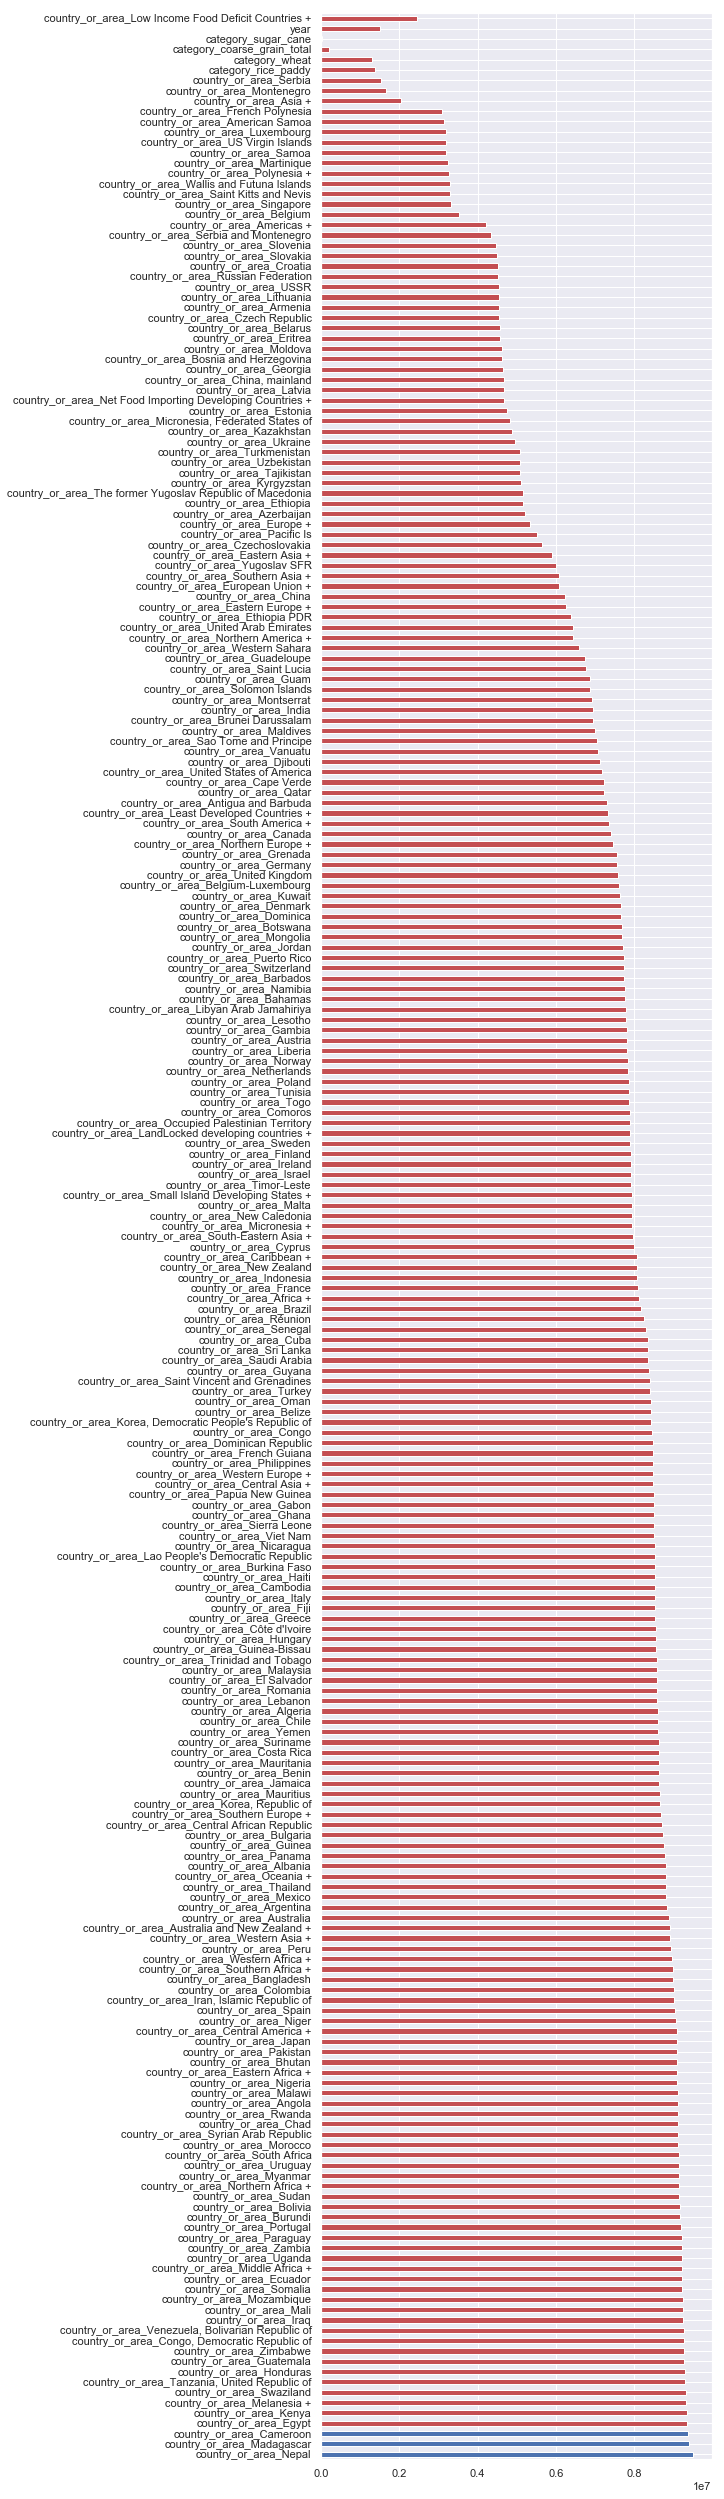

In [128]:
plt.figure(figsize=(7,45))

df_coef3.sort_values(by='coefficients').coef_abs.plot(kind='barh',color=colors);

# Keep These at the bottom and RUN them otherwise you will break git. (Also delete this text before uploading)

In [1]:
!rm global_crops.csv

In [2]:
!rm -r __MACOSX/
